### Import modules and packages. define functions

In [4]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

### Specify experiment directory, condtions and image details
#### Makes dictionary for later storage of results

In [5]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/' #master folder



### for single directory

In [ ]:
results = {"filename":[],
           "earlychannelno":[],"latechannelno":[],"synapsechannelno":[],"Autofluorescencedir":[],
           "Early colour - spots mask":[],
           "Late colour - spots mask":[],
           "Late plus early colour - spots mask":[],
           "Synapse colour - spots mask":[],
           "exp condition":[],
           "Early colour - Raw mean intensity":[],
           "Late colour - Raw mean intensity":[],
           "Synapse colour - Raw mean intensity":[],
           "Global Mean colour bias of a pixel (early=-1<x<1=late)":[],
           "Global Mean colour bias of a pixel (early=-1<x<1=late) Raw":[],
           "Global Mean colour bias of a pixel (early=-1<x<1=late) Normd":[],
           "Mean correlation coefficient early/late":[],
           "Early colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Late colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Synapse colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Early colour - Total no. of spots in FOV":[],#based on spot segmentation mask
           "Late colour - Total no. of spots in FOV":[],#based on spot segmentation mask
           "Synapse colour - Total no. of spots in FOV":[],#based on spot segmentation mask
           "Early colour - Mean spot area [nm]":[],#based on spot segmentation mask
           "Late colour - Mean spot area [nm]":[],#based on spot segmentation mask
           "Synapse colour - Mean spot area [nm]":[],#based on spot segmentation mask
           "Early colour - masked by synapses":[],#based on synapse spot segmentation mask
           "Late colour - masked by synapses":[],#based on synapse spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late)":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late) Raw":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late) Normd":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)":[], #based on synapse spot segmentation mask
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw":[],#based on synapse spot segmentation mask
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd":[],#based on synapse spot segmentation mask
           "Early colour/Synapse colour corr (Mean intensity of spots)":[],
           "Late colour/Synapse colour corr (Mean intensity of spots)":[],
           "Mean colour bias of a pixel - shifted to pos values (early=0)":[],
           "Correlation between colour bias (0 shifted) and synapse intensity":[]}

histogram_results={"filename":[],"exp condition":[],
           "Early colour - Flattened histogram":[],
           "Early colour - Flattened histogram of image normd to internal max":[],
           "Late colour - Flattened histogram":[],
           "Late colour - Flattened histogram of image normd to internal max":[],
           "Synapse colour - Flattened histogram":[],
           "Synapse colour - Flattened histogram of image normd to internal max":[],
           "Early colour - Flattened histogram of image normd to internal max":[],
           "Late colour - Flattened histogram of image normd to internal max":[],
           "Synapse colour - Flattened histogram of image normd to internal max":[],
           "Global Colour bias of a pixel (early=-1<x<1=late) - Histogram":[],
           "Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram":[],
           "Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram":[],  
           "Colour bias of a pixel (early=-1<x<1=late) - Histogram":[],#based on early spot segmentation mask
           "Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram":[],#based on early spot segmentation mask
           "Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram":[],#based on early spot segmentation mask  
           "Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram":[],#based on early spot segmentation mask  
           "Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram":[],#based on synapse spot segmentation mask
           "Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram":[],#based on synapse spot segmentation mask
           "Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram":[]}#based on synapse spot segmentation mask

regionprops_results={"Early colour - regionprops":[],
           "Late colour - regionprops":[],
           "Synapse colour - regionprops":[],
           "Late + early colour combined - regionprops":[]}
    
synapse_results={"filename":[],
           "exp condition":[],
           "Early colour - Mean intensity":[], #based on spot segmentation
           "Late colour - Mean intensity":[],#based on spot segmentation
           "Synapse colour - Mean intensity":[],#based on spot segmentation
           "Synapse Area":[], 
           "Mean colour bias of synapse (early=-1<x<1=late)":[],
           "Is new synapse (1=new, 0=old)":[],
           "Correlation between late colour and synapse intensity":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
for i in range(0,len(filelist)):
    if filelist[i].endswith(".nd2"): #& ("60x" in str(filelist[i]))==True:
        results["filename"].append(filelist[i])
        histogram_results["filename"].append(filelist[i])
        regionprops_results["filename"].append(filelist[i])
        results["exp condition"].append(filelist[i].split('/')[-2])
        histogram_results["exp condition"].append(filelist[i].split('/')[-2])
        regionprops_results["exp condition"].append(filelist[i].split('/')[-2])
        channeldir="/".join(filelist[0].split("/")[:-1])
        exec(open(channeldir+"/channels.txt").read())
        results["earlychannelno"].append(earlychannelno)
        results["latechannelno"].append(latechannelno)
        results["synapsechannelno"].append(synapsechannelno)
        autofdir=channeldir+"/Ctrl_Autofluorescence"
        autofdircheck=Path(channeldir+"/Ctrl_Autofluorescence")
        if autofdircheck.exists():
            results["Autofluorescencedir"].append(autofdir)
        else:
            results["Autofluorescencedir"].append(0)  

### for multiple directories

In [6]:
results = {"filename":[],
           "earlychannelno":[],"latechannelno":[],"synapsechannelno":[],"Autofluorescencedir":[],
           "Earlycontroldir":[],"Latecontroldir":[],
           "Early colour - spots mask":[],
           "Late colour - spots mask":[],
           "Late plus early colour - spots mask":[],
           "Synapse colour - spots mask":[],
           "exp condition":[],
           "Early colour - Raw mean intensity":[],
           "Late colour - Raw mean intensity":[],
           "Synapse colour - Raw mean intensity":[],
           "Global Mean colour bias of a pixel (early=-1<x<1=late)":[],
           "Global Mean colour bias of a pixel (early=-1<x<1=late) Raw":[],
           "Global Mean colour bias of a pixel (early=-1<x<1=late) Normd":[],
           "Mean correlation coefficient early/late":[],
           "Early colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Late colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Synapse colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Early colour - Total no. of spots in FOV":[],#based on spot segmentation mask
           "Late colour - Total no. of spots in FOV":[],#based on spot segmentation mask
           "Synapse colour - Total no. of spots in FOV":[],#based on spot segmentation mask
           "Early colour - Mean spot area [nm]":[],#based on spot segmentation mask
           "Late colour - Mean spot area [nm]":[],#based on spot segmentation mask
           "Synapse colour - Mean spot area [nm]":[],#based on spot segmentation mask
           "Early colour - masked by synapses":[],#based on synapse spot segmentation mask
           "Late colour - masked by synapses":[],#based on synapse spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late)":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late) Raw":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late) Normd":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF":[],#based on early spot segmentation mask
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)":[], #based on synapse spot segmentation mask
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw":[],#based on synapse spot segmentation mask
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd":[],#based on synapse spot segmentation mask
           "Early colour/Synapse colour corr (Mean intensity of spots)":[],
           "Late colour/Synapse colour corr (Mean intensity of spots)":[],
           "Mean colour bias of a pixel - shifted to pos values (early=0)":[],
           "Correlation between colour bias (0 shifted) and synapse intensity":[],
           "Early colour - Mean intensity of spots Normd to ctrls":[],
           "Late colour - Mean intensity of spots Normd to ctrls":[],
           "Early colour Normd to ctrl - masked by synapses":[],
           "Late colour Normd to ctrl - masked by synapses":[],
           "Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls":[],
           "Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd to ctrls":[],
           "Early colour - Mean intensity Normd to ctrls":[],
           "Late colour - Mean intensity Normd to ctrls":[],
           "Global Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls":[],
           "Early colour/Synapse colour corr (Mean intensity of spots norm to ctrl)":[],
           "Late colour/Synapse colour corr (Mean intensity of spots norm to ctrl)":[]}

histogram_results={"filename":[],"exp condition":[],
           "Early colour - Flattened histogram":[],
           "Early colour - Flattened histogram of image normd to internal max":[],
           "Late colour - Flattened histogram":[],
           "Late colour - Flattened histogram of image normd to internal max":[],
           "Synapse colour - Flattened histogram":[],
           "Synapse colour - Flattened histogram of image normd to internal max":[],
           "Early colour - Flattened histogram of image normd to internal max":[],
           "Late colour - Flattened histogram of image normd to internal max":[],
           "Synapse colour - Flattened histogram of image normd to internal max":[],
           "Global Colour bias of a pixel (early=-1<x<1=late) - Histogram":[],
           "Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram":[],
           "Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram":[],  
           "Colour bias of a pixel (early=-1<x<1=late) - Histogram":[],#based on early spot segmentation mask
           "Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram":[],#based on early spot segmentation mask
           "Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram":[],#based on early spot segmentation mask  
           "Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram":[],#based on early spot segmentation mask  
           "Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram":[],#based on synapse spot segmentation mask
           "Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram":[],#based on synapse spot segmentation mask
           "Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram":[],#based on synapse spot segmentation mask
           "Colour bias of a pixel (early=-1<x<1=late) Normd to ctrls - Histogram":[],
           "Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd to ctrls - Histogram":[],
           "Global Colour bias of a pixel (early=-1<x<1=late) Normd to ctrls - Histogram":[]}
                   
regionprops_results={"filename":[],
           "exp condition":[],"Early colour - regionprops":[],
           "Late colour - regionprops":[],
           "Synapse colour - regionprops":[],
           "Late + early colour combined - regionprops":[]}
    
synapse_results={"filename":[],
           "exp condition":[],
           "Early colour - Mean intensity":[], #based on spot segmentation
           "Late colour - Mean intensity":[],#based on spot segmentation
           "Synapse colour - Mean intensity":[],#based on spot segmentation
           "Synapse Area":[], 
           "Mean colour bias of synapse (early=-1<x<1=late)":[],
           "Is new synapse (1=new, 0=old)":[],
           "Correlation between late colour and synapse intensity":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
for i in range(0,len(filelist)):
    if "_use" in str(filelist[i]):
        if ("Agg" in str(filelist[i]))==False:
            if filelist[i].endswith(".nd2"): #& ("60x" in str(filelist[i]))==True:
                results["filename"].append(filelist[i])
                histogram_results["filename"].append(filelist[i])
                regionprops_results["filename"].append(filelist[i])
                results["exp condition"].append(filelist[i].split('/')[-2])
                histogram_results["exp condition"].append(filelist[i].split('/')[-2])
                regionprops_results["exp condition"].append(filelist[i].split('/')[-2])
                channeldir="/".join(filelist[i].split("/")[:-2])
                exec(open(channeldir+"/channels.txt").read())
                results["earlychannelno"].append(earlychannelno)
                results["latechannelno"].append(latechannelno)
                results["synapsechannelno"].append(synapsechannelno)
                autofdir=channeldir+"/Ctrl_Autofluorescence"
                autofdircheck=Path(channeldir+"/Ctrl_Autofluorescence")
                if autofdircheck.exists():
                    results["Autofluorescencedir"].append(autofdir)
                else:
                    results["Autofluorescencedir"].append(0) 
                earlycontrolcheck=Path(channeldir+"/Livectrl_early_immediatemount")
                if earlycontrolcheck.exists():
                    results["Earlycontroldir"].append(channeldir+"/Livectrl_early_immediatemount")
                else:
                    results["Earlycontroldir"].append(channeldir+"/Fixedctrl_early_immediatemount")
                latecontrolcheck=Path(channeldir+"/Livectrl_onlysecondcolour_1day")
                if earlycontrolcheck.exists():
                    results["Latecontroldir"].append(channeldir+"/Livectrl_onlysecondcolour_1day")
                else:
                    results["Latecontroldir"].append(channeldir+"/Fixedctrl_onlysecondcolour_1day")                

In [7]:
results["Earlycontroldir"][900]

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180602_Turnover_Bic_Timepoints_nb635first_580second_use/Fixedctrl_early_immediatemount'

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180602_Turnover_Bic_Timepoints_nb635first_580second_use/7hr_DMSO/20180602_15_009.nd2


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180620_Turnover_Bic_TNR_Timepoints_nb635first_580second_use/6hr_DMSO/20180620_16_010.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180501_Turnover_3colours_Bic_TTX_nb580first_635second_use/TNR/1Day_Bic/20180501_TNR_08_001.nd2


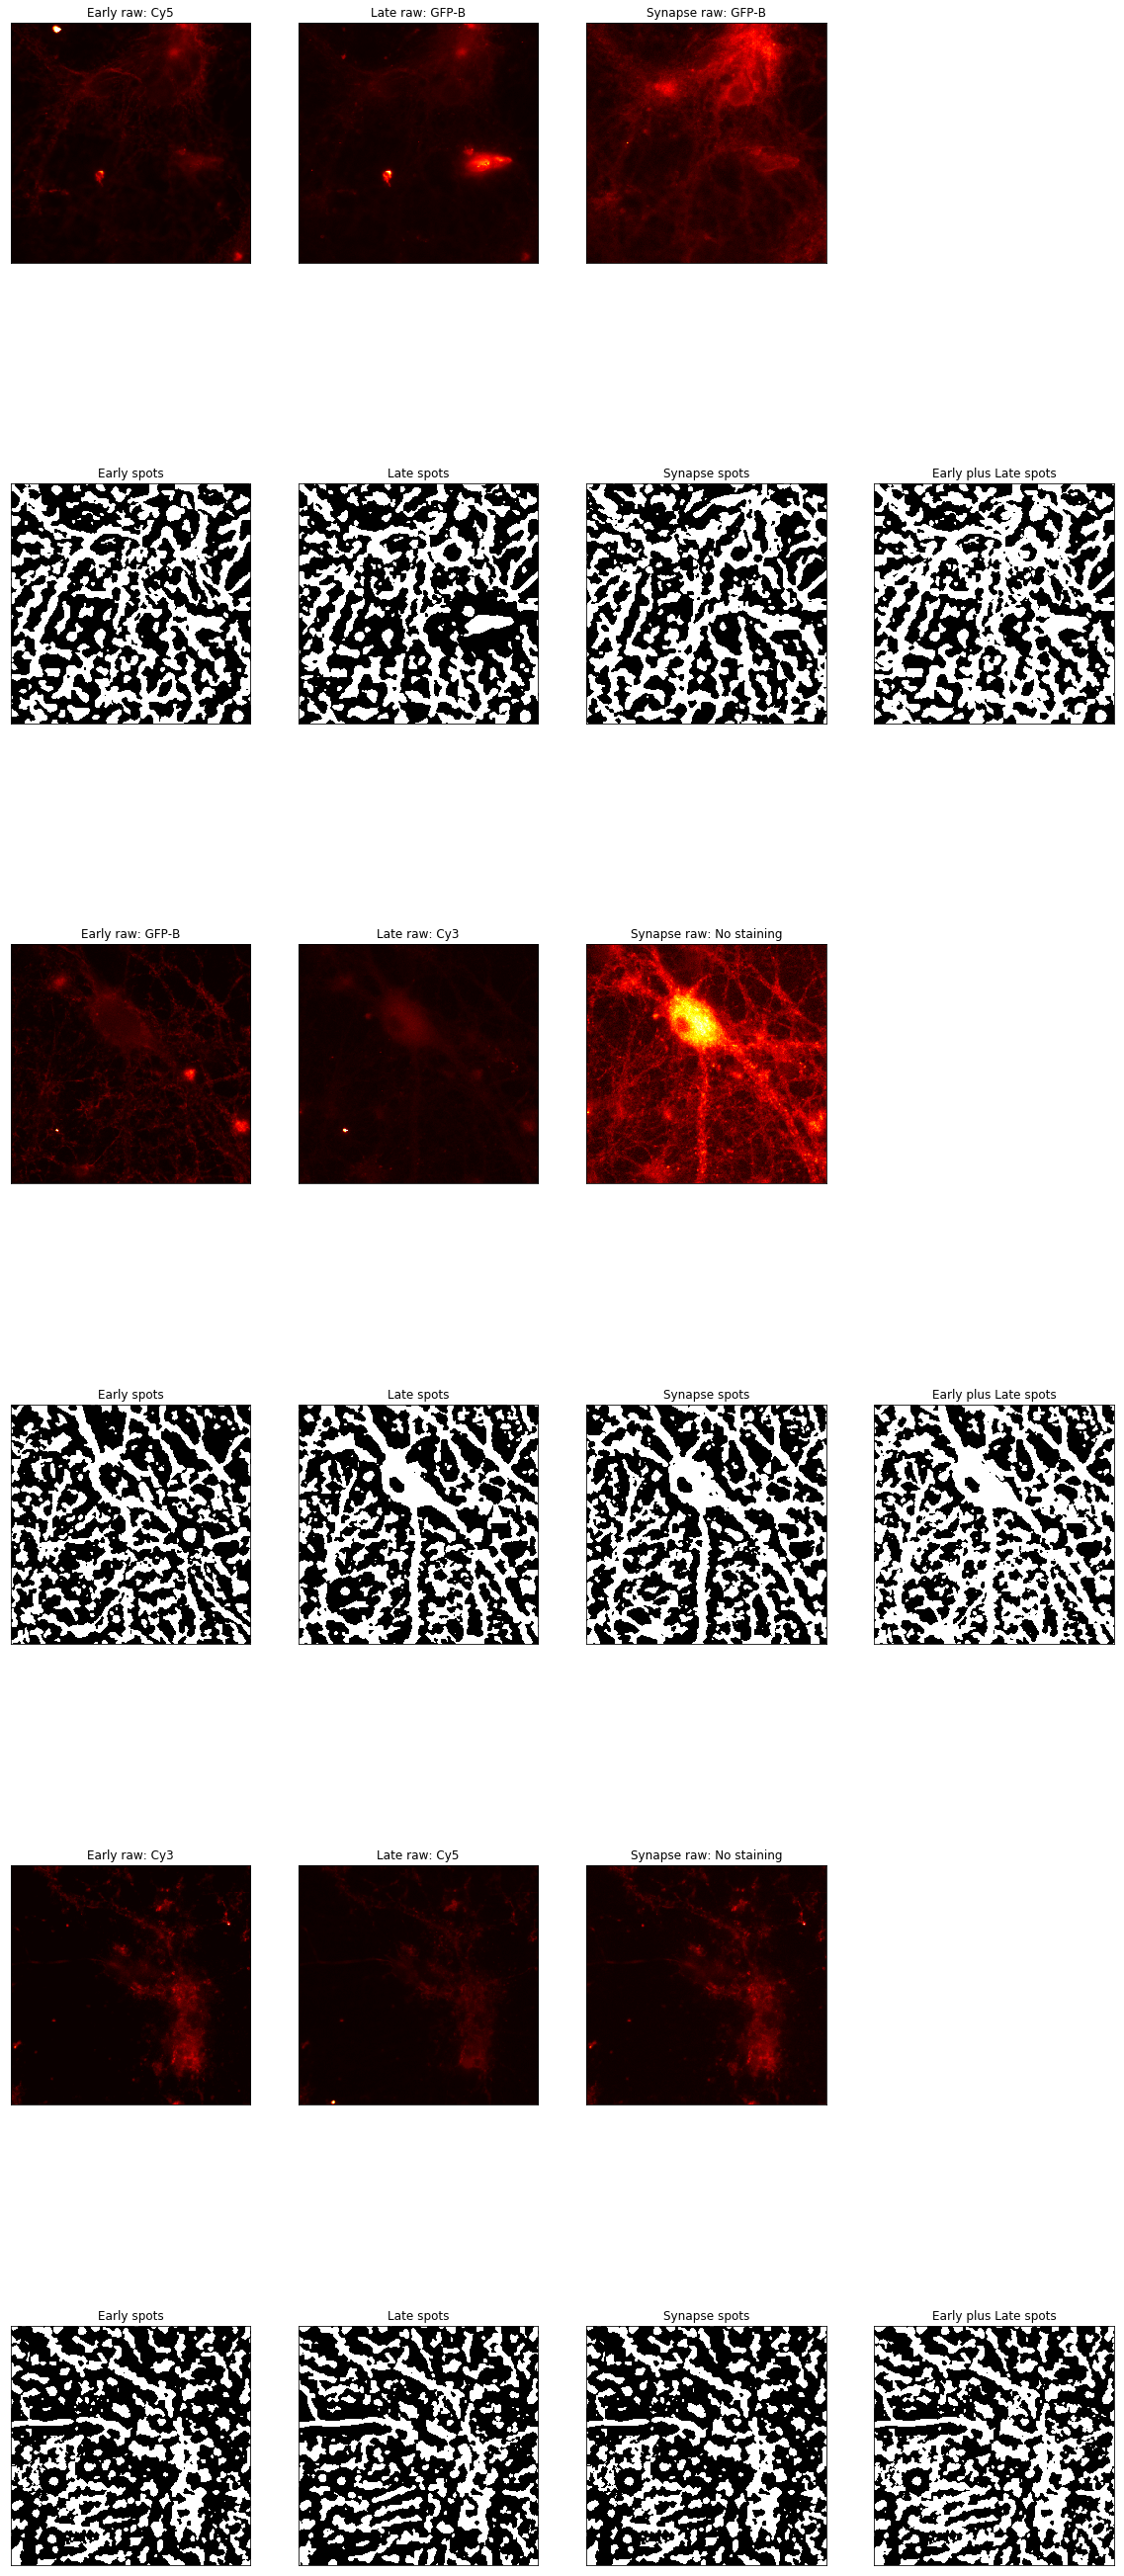

In [10]:
fig=plt.figure(figsize=(20,50))
figno=1
for im in range(0,3):
    randomno=np.random.randint(1,len(results["filename"]))
    early_channel_no=results["earlychannelno"][randomno]
    late_channel_no=results["latechannelno"][randomno]
    synapse_channel_no=results["synapsechannelno"][randomno]
    with ND2Reader(results["filename"][randomno]) as images:
        print(results["filename"][randomno])
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        if synapse_channel_no>0:
            synapse_image=images[synapse_channel_no-1]
            [channel1name, channel2name, channel3name]=early_image.metadata['channels']
            if early_channel_no==1:
                early_channelname=channel1name
                if late_channel_no==2:
                    late_channelname=channel2name
                    synapse_channelname=channel3name
                else:
                    late_channelname=channel3name
                    synapse_channelname=channel2name
            if early_channel_no==2:
                early_channelname=channel2name
                if late_channel_no==3:
                    late_channelname=channel3name
                    synapse_channelname=channel1name
                else:
                    late_channelname=channel1name
                    synapse_channelname=channel3name
            if early_channel_no==3:
                early_channelname=channel3name
                if late_channel_no==2:
                    late_channelname=channel2name
                    synapse_channelname=channel1name
                else:
                    late_channelname=channel1name
                    synapse_channelname=channel2name
        else:
            synapse_image=np.zeros((512,512))        
            [channel1name, channel2name]=early_image.metadata['channels']
        if early_channel_no==1:
            early_channelname=channel1name
            late_channelname=channel2name
        else:
            early_channelname=channel2name
            late_channelname=channel1name
            synapse_channelname='No staining'
    #smoothing with gaussian filter for noise reduction
    #can play with sigma
    sigmagauss=2.5 #should be roughly half the size of the object you are detecting
    early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
    late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)
    synapse_smooth=ndi.filters.gaussian_filter(synapse_image,sigmagauss)
    #adaptive thresholding - bg found by mean filter with SE
    istruct=51 #for SE
    struct = (np.mgrid[:istruct,:istruct][0] - np.floor(istruct/2))**2 + (np.mgrid[:istruct,:istruct][1] - np.floor(istruct/2))**2 <= np.floor(istruct/2)**2
    bg_early = rank.mean(early_smooth, selem=struct)
    bg_late = rank.mean(late_smooth, selem=struct)
    bg_synapse = rank.mean(synapse_smooth, selem=struct)
    early_spots = early_smooth >= bg_early
    late_spots = late_smooth >= bg_late
    synapse_spots = synapse_smooth >= bg_synapse
    lateplusearly_spots = np.add(late_spots,early_spots)
    lateplusearly_spots[lateplusearly_spots==2]=1
    #improve with binary hole filling
    #early_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(early_spots))
    #late_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(late_spots))
    #improve with binary closing
    #i2 = 3
    #struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
    #pad_size = i+2 #pad the spots image to avoid artifacts at the edges
    #padded_early_spots = np.pad(early_spots_holes_filled,pad_size,mode='reflect')
    #padded_late_spots = np.pad(late_spots_holes_filled,pad_size,mode='reflect')
    #early_spots_final = ndi.binary_closing(np.logical_not(padded_early_spots),structure=struct2)
    #late_spots_final = ndi.binary_closing(np.logical_not(padded_late_spots),structure=struct2)
    #remove the padding from before
    #early_spots_final = early_spots_final[pad_size:-pad_size,pad_size:-pad_size]
    #late_spots_final = late_spots_final[pad_size:-pad_size,pad_size:-pad_size]
    #figures    
    fig.add_subplot(6,4,figno)
    plt.imshow(early_image,interpolation='none',cmap='hot',vmin=1.5*early_image.min(),vmax=0.95*early_image.max())
    plt.title('Early raw: '+early_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+1)
    plt.imshow(late_image,interpolation='none',cmap='hot')
    plt.title('Late raw: '+late_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+2)
    plt.imshow(synapse_image,interpolation='none',cmap='hot')
    plt.title('Synapse raw: '+synapse_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+4)
    plt.imshow(early_spots,interpolation='none',cmap='gray')
    plt.title('Early spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+5)
    plt.imshow(late_spots,interpolation='none',cmap='gray')
    plt.title('Late spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+6)
    plt.imshow(synapse_spots,interpolation='none',cmap='gray')
    plt.title('Synapse spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,4,figno+7)
    plt.imshow(lateplusearly_spots,interpolation='none',cmap='gray')
    plt.title('Early plus Late spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    figno=figno+8 

#### After optimizing, run below to make segmentation masks for all images

In [11]:
print('Total number of images: ' + str(len(results['filename'])))

for im in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(im+1) + 'of ' + str(len(results['filename'])))
    early_channel_no=results["earlychannelno"][im]
    late_channel_no=results["latechannelno"][im]
    synapse_channel_no=results["synapsechannelno"][im]
    with ND2Reader(results["filename"][im]) as images:
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        if synapse_channel_no>0:
            synapse_image=images[synapse_channel_no-1]
        else:
            synapse_image=np.zeros((512,512))       
    #smoothing with gaussian filter for noise reduction
    #can play with sigma
    # sigmagauss=3 #taken from previous cell
    early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
    late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)
    synapse_smooth = ndi.filters.gaussian_filter(synapse_image,sigmagauss)
    early_image=np.divide(early_image,16383.)
    late_image=np.divide(late_image,16383.)
    synapse_image=np.divide(synapse_image,16383.)
    #adaptive thresholding - bg found by mean filter with SE
    bg_early = rank.mean(early_smooth, selem=struct)
    bg_late = rank.mean(late_smooth, selem=struct)
    bg_synapse = rank.mean(synapse_smooth, selem=struct)
    early_spots = early_smooth >= bg_early
    late_spots = late_smooth >= bg_late
    synapse_spots = synapse_smooth >= bg_synapse
    lateplusearly_spots = np.add(late_spots,early_spots)
    lateplusearly_spots[lateplusearly_spots==2]=1
    #improve with binary hole filling
    #early_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(early_spots))
    #late_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(late_spots))
    #improve with binary closing
    #i2 = 3
    #struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
    #pad_size = i+2 #pad the spots image to avoid artifacts at the edges
    #padded_early_spots = np.pad(early_spots_holes_filled,pad_size,mode='reflect')
    #padded_late_spots = np.pad(late_spots_holes_filled,pad_size,mode='reflect')
    #early_spots_final = ndi.binary_closing(np.logical_not(padded_early_spots),structure=struct2)
    #late_spots_final = ndi.binary_closing(np.logical_not(padded_late_spots),structure=struct2)
    #remove the padding from before
    #early_spots_final = early_spots_final[pad_size:-pad_size,pad_size:-pad_size]
    #late_spots_final = late_spots_final[pad_size:-pad_size,pad_size:-pad_size]
    results["Early colour - spots mask"].append(early_spots)
    results["Late colour - spots mask"].append(late_spots)
    results["Synapse colour - spots mask"].append(synapse_spots)
    results["Late plus early colour - spots mask"].append(lateplusearly_spots)          
os.system('say "Segmentation complete"')

Total number of images: 1904
Calculating image no 1of 1904


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Calculating image no 2of 1904
Calculating image no 3of 1904
Calculating image no 4of 1904


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Calculating image no 5of 1904
Calculating image no 6of 1904
Calculating image no 7of 1904
Calculating image no 8of 1904
Calculating image no 9of 1904
Calculating image no 10of 1904
Calculating image no 11of 1904
Calculating image no 12of 1904
Calculating image no 13of 1904
Calculating image no 14of 1904
Calculating image no 15of 1904


/anaconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Calculating image no 16of 1904
Calculating image no 17of 1904
Calculating image no 18of 1904
Calculating image no 19of 1904
Calculating image no 20of 1904
Calculating image no 21of 1904
Calculating image no 22of 1904
Calculating image no 23of 1904
Calculating image no 24of 1904
Calculating image no 25of 1904
Calculating image no 26of 1904
Calculating image no 27of 1904
Calculating image no 28of 1904
Calculating image no 29of 1904
Calculating image no 30of 1904
Calculating image no 31of 1904
Calculating image no 32of 1904
Calculating image no 33of 1904
Calculating image no 34of 1904
Calculating image no 35of 1904
Calculating image no 36of 1904
Calculating image no 37of 1904
Calculating image no 38of 1904
Calculating image no 39of 1904
Calculating image no 40of 1904
Calculating image no 41of 1904
Calculating image no 42of 1904
Calculating image no 43of 1904
Calculating image no 44of 1904
Calculating image no 45of 1904
Calculating image no 46of 1904
Calculating image no 47of 1904
Calculat

0

### Make folder for results and save segmentation

In [ ]:
os.mkdir(expdir+'results/')

In [15]:
len(results["filename"])

1904

In [20]:
from copy import deepcopy
resultsbackup2=deepcopy(results)

In [ ]:
results=np.load('/Users/taldankovich/Downloads/myresults.npy')

In [33]:
results=deepcopy(resultsbackup2)

In [28]:
len(results["Early Image - Raw ean intensity"])

KeyError: 'Early Image - Raw ean intensity'

In [ ]:
#save segmentation results
np.save(expdir+'/results/EarlySpots.npy',results["Early colour - spots mask"])
np.save(expdir+'/results/LateSpots.npy',results["Late colour - spots mask"])
np.save(expdir+'/results/SynapseSpots.npy',results["Synapse colour - spots mask"])
np.save(expdir+'/results/EarlyPlusLateSpots.npy',results["Late plus early colour - spots mask"])

In [ ]:
#load segmentation results
EarlySpots=np.load(expdir+'/results/EarlySpots.npy')
LateSpots=np.load(expdir+'/results/LateSpots.npy')
SynapseSpots=np.load(expdir+'/results/SynapseSpots.npy')
EarlyPlusLateSpots=np.load(expdir+'/results/EarlyPlusLateSpots.npy')
results["Early colour - spots mask"]=EarlySpots
results["Late colour - spots mask"]=LateSpots
results["Synapse colour - spots mask"]=SynapseSpots
results["Late plus early colour - spots mask"]=EarlyPlusLateSpots

In [ ]:
results["filename"]

### Batch analyse images, after creating the segmentation masks

In [34]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    early_channel_no=results["earlychannelno"][i]
    late_channel_no=results["latechannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    if synapse_channel_no>0:
        synapse_flag=True
        print('has synapse values')
    else:
        synapse_flag=False
    with ND2Reader(results["filename"][i]) as images:
        #read the images
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        if synapse_flag:
            synapse_image=images[synapse_channel_no-1]
    #convert to array
    early_image=early_image.astype(np.int16)
    late_image=late_image.astype(np.int16)
    if synapse_flag:
        synapse_image=synapse_image.astype(np.int16)
    #preserve the raw images
    early_image_raw = deepcopy(early_image)
    late_image_raw=deepcopy(late_image)
    if synapse_flag:
        synapse_image_raw=deepcopy(synapse_image)
    spots_late_minus_early_int_raw=early_image_raw+late_image_raw
    #normalize intensity to value between 0 and 1
    early_image=np.divide(early_image,16383.)
    late_image=np.divide(late_image,16383.)
    if synapse_flag:
        synapse_image=np.divide(synapse_image,16383.)
    #make normalized image;divide each pixel by max in the channel in that image
    early_image_norm=deepcopy(early_image)
    early_image_norm=early_image_norm-np.mean(early_image_norm)
    late_image_norm=deepcopy(late_image)
    late_image_norm=late_image_norm-np.mean(late_image_norm)
    if synapse_flag:
        synapse_image_norm=deepcopy(synapse_image)
        synapse_image_norm=synapse_image_norm-np.mean(synapse_image_norm)
    #small detour to calculate the mean fluorescence of controls - early or late colour alone
    #1- earlycolour
    ctrlearlys={"filename":[]}
    ctrlearly=results["Earlycontroldir"][i]
    pathearly = os.path.dirname(ctrlearly+"/")
    filelistearly = []
    for root, _, filenames in os.walk(pathearly):
         for filename in filenames:
             filelistearly.append(os.path.join(root, filename))
    for l in range(0,len(filelistearly)):
        if filelistearly[l].endswith(".nd2"): 
            ctrlearlys["filename"].append(filelistearly[l])
    earlycolour_ctrls=np.zeros((len(ctrlearlys["filename"]),1))
    for im in range(0,len(ctrlearlys["filename"])):
        with ND2Reader(ctrlearlys["filename"][im]) as images:
            early_image_ctrl=images[early_channel_no-1]
        #convert to array
        early_image_ctrl=early_image_ctrl.astype(np.int16)
        #normalize intensity to value between 0 and 1
        early_image_ctrl=np.divide(early_image_ctrl,16383.)
        #append mean intensity
        earlycolour_ctrls[im]=np.mean(early_image_ctrl)
    #2- latecolour
    ctrllates={"filename":[]}
    ctrllate=results["Latecontroldir"][i]
    pathlate = os.path.dirname(ctrllate+"/")
    filelistlate = []
    for root, _, filenames in os.walk(pathlate):
         for filename in filenames:
             filelistlate.append(os.path.join(root, filename))
    for l in range(0,len(filelistlate)):
        if filelistlate[l].endswith(".nd2"): 
            ctrllates["filename"].append(filelistearly[l])
    latecolour_ctrls=np.zeros((len(ctrllates["filename"]),1))
    for im in range(0,len(ctrllates["filename"])):
        with ND2Reader(ctrllates["filename"][im]) as images:
            late_image_ctrl=images[late_channel_no-1]
        #convert to array
        late_image_ctrl=late_image_ctrl.astype(np.int16)
        #normalize intensity to value between 0 and 1
        late_image_ctrl=np.divide(late_image_ctrl,16383.)
        #append mean intensity
        latecolour_ctrls[im]=np.mean(late_image_ctrl)
    #average the vectors
    early_ctrl_mean=np.mean(earlycolour_ctrls)
    late_ctrl_mean=np.mean(latecolour_ctrls)
    #make image normalized to the control
    early_image_normtoctrl=deepcopy(early_image)
    early_image_normtoctrl=np.divide(early_image_normtoctrl,early_ctrl_mean)
    late_image_normtoctrl=deepcopy(late_image)
    late_image_normtoctrl=np.divide(late_image_normtoctrl,late_ctrl_mean)
    #small detour to calculate the autofluorescence
    autof={"filename":[]}
    autofpath=results["Autofluorescencedir"][i]
    if autofpath==0:
        early_autoint_mean=0
        late_autoint_mean=0
        if synapse_flag:
            synapse_autoint_mean=0
    else:
        pathy = os.path.dirname(autofpath+"/")  
        autoffilelist = []
        for root, _, filenames in os.walk(pathy):
             for filename in filenames:
                 autoffilelist.append(os.path.join(root, filename))
        for l in range(0,len(autoffilelist)):
            if autoffilelist[l].endswith(".nd2"): 
                autof["filename"].append(autoffilelist[l])
        earlycolour_autoint=np.zeros((len(autof["filename"]),1))
        latecolour_autoint=np.zeros((len(autof["filename"]),1))
        if synapse_flag:
            synapsecolour_autoint=np.zeros((len(autof["filename"]),1))
        for im in range(0,len(autof["filename"])):
            with ND2Reader(autof["filename"][im]) as images:
                early_image_auto=images[early_channel_no-1]
                late_image_auto=images[late_channel_no-1]
                if synapse_flag:
                    synapse_image_auto=images[synapse_channel_no-1]
            #convert to array
            early_image_auto=early_image_auto.astype(np.int16)
            late_image_auto=late_image_auto.astype(np.int16)
            if synapse_flag:
                synapse_image_auto=synapse_image_auto.astype(np.int16)
            #normalize intensity to value between 0 and 1
            early_image_auto=np.divide(early_image_auto,16383.)
            late_image_auto=np.divide(late_image_auto,16383.)
            if synapse_flag:
                synapse_image_auto=np.divide(synapse_image_auto,16383.)
            #append mean intensity
            earlycolour_autoint[im]=np.mean(early_image_auto)
            latecolour_autoint[im]=np.mean(late_image_auto)  
            if synapse_flag:
                synapsecolour_autoint[im]=np.mean(synapse_image_auto)
        #average the vectors
        early_autoint_mean=np.mean(earlycolour_autoint)
        late_autoint_mean=np.mean(latecolour_autoint)
        if synapse_flag:
            synapse_autoint_mean=np.mean(synapsecolour_autoint)   
    #make image histograms before subtracting autofluorescence
    early_hist,_ = np.histogram(early_image,bins=np.linspace(0.,1.,50))
    late_hist,_ = np.histogram(late_image,bins=np.linspace(0.,1.,50))
    if synapse_flag:
        synapse_hist,_ = np.histogram(synapse_image,bins=np.linspace(0.,1.,50))
    early_hist_norm,_ = np.histogram(early_image_norm,bins=np.linspace(0.,1.,50))
    late_hist_norm,_ = np.histogram(late_image_norm,bins=np.linspace(0.,1.,50))
    if synapse_flag:
        synapse_hist_norm,_ = np.histogram(synapse_image_norm,bins=np.linspace(0.,1.,50))
    #subtract autofluorescence in each channel; subtract the normalized pixel value times the max autofluorescence int
    early_image=np.subtract(early_image,early_autoint_mean)
    early_image[early_image<0]=0
    late_image=np.subtract(late_image,late_autoint_mean)
    late_image[late_image<0]=0
    if synapse_flag:
        synapse_image=np.subtract(synapse_image,synapse_autoint_mean)
        synapse_image[synapse_image<0]=0
    early_image_norm_minusauto=np.subtract(early_image_norm,early_autoint_mean) 
    early_image_norm_minusauto[early_image_norm_minusauto<0]=0
    late_image_norm_minusauto=np.subtract(late_image_norm,late_autoint_mean)
    late_image_norm_minusauto[late_image_norm_minusauto<0]=0
    if synapse_flag:
        synapse_image_norm_minusauto=np.subtract(synapse_image_norm,synapse_autoint_mean)
        synapse_image_norm_minusauto[synapse_image_norm_minusauto<0]=0            
    #read spots masks
    early_spots=results["Early colour - spots mask"][i]
    late_spots=results["Late colour - spots mask"][i]
    lateplusearly_spots=results["Late plus early colour - spots mask"][i]
    if synapse_flag:
        synapse_spots=results["Synapse colour - spots mask"][i]
    #label the spots
    spots_early_labels,_ = ndi.label(early_spots)
    spots_late_labels,_ = ndi.label(late_spots)
    spots_earlypluslate_labels,_ = ndi.label(lateplusearly_spots)
    if synapse_flag:
        spots_synapse_labels,_ = ndi.label(synapse_spots)

    #calculate results
    #make empty vectors                                   
    early_spots_intensities=np.zeros((len(np.unique(spots_early_labels)),1))
    early_spots_intensities_normtoctrl=np.zeros((len(np.unique(spots_early_labels)),1))
    early_spots_areas=np.zeros((len(np.unique(spots_early_labels)),1))
    late_spots_intensities=np.zeros((len(np.unique(spots_late_labels)),1))
    late_spots_intensities_normtoctrl=np.zeros((len(np.unique(spots_late_labels)),1))
    late_spots_areas=np.zeros((len(np.unique(spots_late_labels)),1))
    spots_late_minus_early_int=np.zeros((len(np.unique(spots_early_labels)),1))
    spots_late_minus_early_int_norm=np.zeros((len(np.unique(spots_early_labels)),1))
    spots_late_minus_early_int_raw=np.zeros((len(np.unique(spots_early_labels)),1))
    spots_late_minus_early_int_norm_minusauto=np.zeros((len(np.unique(spots_early_labels)),1))
    spots_late_minus_early_int_normtoctrl=np.zeros((len(np.unique(spots_early_labels)),1))
    spots_bias_image_hists=np.zeros((len(np.unique(spots_early_labels)),49))
    spots_bias_image_hists_raw=np.zeros((len(np.unique(spots_early_labels)),49))
    spots_bias_image_hists_norm=np.zeros((len(np.unique(spots_early_labels)),49))
    spots_bias_image_hists_norm_minusauto=np.zeros((len(np.unique(spots_early_labels)),49))
    spots_bias_image_hists_normtoctrl=np.zeros((len(np.unique(spots_early_labels)),49))
    if synapse_flag:
        synapse_spots_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1))
        synapse_spots_areas=np.zeros((len(np.unique(spots_synapse_labels)),1))
        early_atsynapses_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1))   
        late_atsynapses_intensities=np.zeros((len(np.unique(spots_synapse_labels)),1)) 
        early_atsynapses_intensities_normtoctrl=np.zeros((len(np.unique(spots_synapse_labels)),1))   
        late_atsynapses_intensities_normtoctrl=np.zeros((len(np.unique(spots_synapse_labels)),1)) 
        spots_late_minus_early_atsynapses_int=np.zeros((len(np.unique(spots_synapse_labels)),1))
        spots_late_minus_early_int_raw_syn=np.zeros((len(np.unique(spots_synapse_labels)),1))
        spots_late_minus_early_int_norm_minusauto_syn=np.zeros((len(np.unique(spots_synapse_labels)),1))
        spots_late_minus_early_int_norm_syn=np.zeros((len(np.unique(spots_synapse_labels)),1))
        spots_late_minus_early_int_syn=np.zeros((len(np.unique(spots_synapse_labels)),1))
        spots_late_minus_early_int_normtoctrl_syn=np.zeros((len(np.unique(spots_synapse_labels)),1))
        spots_bias_image_hists_syn=np.zeros((len(np.unique(spots_synapse_labels)),49))
        spots_bias_image_hists_raw_syn=np.zeros((len(np.unique(spots_synapse_labels)),49))
        spots_bias_image_hists_norm_syn=np.zeros((len(np.unique(spots_synapse_labels)),49))  
        spots_bias_image_hists_norm_minusauto_syn=np.zeros((len(np.unique(spots_synapse_labels)),49))  
        spots_bias_image_hists_normtoctrl_syn=np.zeros((len(np.unique(spots_synapse_labels)),49))     
    #loop over early spots
    print('no early spots = ' +str(len(np.unique(spots_early_labels))))
    for spotno in np.unique(spots_early_labels)[1:]:
        early_spots_mask = spots_early_labels==spotno
        early_spots_intensities[spotno]=np.nanmean(early_image[early_spots_mask])
        early_spots_intensities_normtoctrl[spotno]=np.nanmean(early_image_normtoctrl[early_spots_mask])
        early_spots_areas[spotno]=np.sum(early_spots_mask)
        #bias image calculation for fluorescence subtracted
        a=late_image[early_spots_mask]
        b=early_image[early_spots_mask]
        spots_bias_image=np.divide([a-b],[a+b])                               
        spots_late_minus_early_int[spotno]=np.nanmean(spots_bias_image)
        spots_bias_image_hist,_= np.histogram([spots_bias_image[~np.isnan(spots_bias_image)]],bins=np.linspace(-1.,1.,50))
        spots_bias_image_hists[spotno]=spots_bias_image_hist                               
        #bias image calculation for raw images
        a=late_image_raw[early_spots_mask]
        b=early_image_raw[early_spots_mask]
        spots_bias_image_raw=np.divide([a-b],[a+b])                               
        spots_late_minus_early_int_raw[spotno]=np.nanmean(spots_bias_image_raw)
        spots_bias_image_hist_raw,_= np.histogram([spots_bias_image_raw[~np.isnan(spots_bias_image_raw)]],bins=np.linspace(-1.,1.,50)) 
        spots_bias_image_hists_raw[spotno]=spots_bias_image_hist_raw    
        #bias image calculation for normalized images
        a=late_image_norm[early_spots_mask]
        b=early_image_norm[early_spots_mask]
        spots_bias_image_norm=np.divide([a-b],[a+b])                               
        spots_late_minus_early_int_norm[spotno]=np.nanmean(spots_bias_image_norm)
        spots_bias_image_hist_norm,_= np.histogram([spots_bias_image_norm[~np.isnan(spots_bias_image_norm)]],bins=np.linspace(-1.,1.,50))
        spots_bias_image_hists_norm[spotno]=spots_bias_image_hist_norm
        #biased images for norm minus autofluorescence 
        a=late_image_norm_minusauto[early_spots_mask]
        b=early_image_norm_minusauto[early_spots_mask]
        spots_bias_image_norm_minusauto=np.divide([a-b],[a+b])                               
        spots_late_minus_early_int_norm_minusauto[spotno]=np.nanmean(spots_bias_image_norm_minusauto)
        spots_bias_image_hist_norm_minusauto,_= np.histogram([spots_bias_image_norm_minusauto[~np.isnan(spots_bias_image_norm_minusauto)]],bins=np.linspace(-1.,1.,50)) 
        spots_bias_image_hists_norm_minusauto[spotno]=spots_bias_image_hist_norm_minusauto 
        #biased images for norm to ctrl 
        a=late_image_normtoctrl[early_spots_mask]
        b=early_image_normtoctrl[early_spots_mask]
        spots_bias_image_normtoctrl=np.divide([a-b],[a+b])                               
        spots_late_minus_early_int_normtoctrl[spotno]=np.nanmean(spots_bias_image_normtoctrl)
        spots_bias_image_hist_normtoctrl,_= np.histogram([spots_bias_image_normtoctrl[~np.isnan(spots_bias_image_normtoctrl)]],bins=np.linspace(-1.,1.,50)) 
        spots_bias_image_hists_normtoctrl[spotno]=spots_bias_image_hist_normtoctrl
    #loop over late spots
    print('no late spots = ' +str(len(np.unique(spots_late_labels))))
    for spotnol in np.unique(spots_late_labels)[1:]:
        late_spots_mask= spots_late_labels==spotnol
        late_spots_intensities[spotnol]=np.nanmean(late_image[late_spots_mask])
        late_spots_intensities_normtoctrl[spotnol]=np.nanmean(late_image_normtoctrl[late_spots_mask])
        late_spots_areas[spotnol]=np.sum(late_spots_mask)
    #loop over synapse spots   
    if synapse_flag:
        print('no synapse spots = ' +str(len(np.unique(spots_synapse_labels))))
        for spotnos in np.unique(spots_synapse_labels)[1:]:
            synapse_spots_mask= spots_synapse_labels==spotnos
            synapse_spots_intensities[spotnos]=np.nanmean(synapse_image[synapse_spots_mask])
            synapse_spots_areas[spotnos]=np.sum(synapse_spots_mask)
            #intensities masked by synapses, calculation
            early_atsynapses_intensities[spotnos]=np.nanmean(early_image[synapse_spots_mask])
            late_atsynapses_intensities[spotnos]=np.nanmean(late_image[synapse_spots_mask])
            early_atsynapses_intensities_normtoctrl[spotnos]=np.nanmean(early_image_normtoctrl[synapse_spots_mask])
            late_atsynapses_intensities_normtoctrl[spotnos]=np.nanmean(late_image_normtoctrl[synapse_spots_mask])
            #calculate bias image at synapses
            #bias image calculation for fluorescence subtracted
            a=late_image[synapse_spots_mask]
            b=early_image[synapse_spots_mask]
            spots_bias_image=np.divide([a-b],[a+b])                               
            spots_late_minus_early_int_syn[spotnos]=np.nanmean(spots_bias_image)
            spots_bias_image_hist,_= np.histogram([spots_bias_image[~np.isnan(spots_bias_image)]],bins=np.linspace(-1.,1.,50)) 
            spots_bias_image_hists_syn[spotnos]=spots_bias_image_hist
            #bias image calculation for raw images
            a=late_image_raw[early_spots_mask]
            b=early_image_raw[early_spots_mask]
            spots_bias_image_raw=np.divide([a-b],[a+b])                               
            spots_late_minus_early_int_raw_syn[spotnos]=np.nanmean(spots_bias_image_raw)
            spots_bias_image_hist_raw,_= np.histogram([spots_bias_image_raw[~np.isnan(spots_bias_image_raw)]],bins=np.linspace(-1.,1.,50)) 
            spots_bias_image_hists_raw_syn[spotnos]=spots_bias_image_hist_raw
            #bias image calculation for normalized images
            a=late_image_norm[early_spots_mask]
            b=early_image_norm[early_spots_mask]
            spots_bias_image_norm=np.divide([a-b],[a+b])                               
            spots_late_minus_early_int_norm_syn[spotnos]=np.nanmean(spots_bias_image_norm)
            spots_bias_image_hist_norm,_= np.histogram([spots_bias_image_norm[~np.isnan(spots_bias_image_norm)]],bins=np.linspace(-1.,1.,50)) 
            spots_bias_image_hists_norm_syn[spotnos]=spots_bias_image_hist_norm                               
            ###biased images for norm minus autofluorescence 
            a=late_image_norm_minusauto[early_spots_mask]
            b=early_image_norm_minusauto[early_spots_mask]
            spots_bias_image_norm_minusauto=np.divide([a-b],[a+b])                               
            spots_late_minus_early_int_norm_minusauto_syn[spotnos]=np.nanmean(spots_bias_image_norm_minusauto)
            spots_bias_image_hist_norm_minusauto,_= np.histogram([spots_bias_image_norm_minusauto[~np.isnan(spots_bias_image_norm_minusauto)]],bins=np.linspace(-1.,1.,50)) 
            spots_bias_image_hists_norm_minusauto_syn[spotnos]=spots_bias_image_hist_norm_minusauto  
            ###biased images for norm to ctrl 
            a=late_image_normtoctrl[early_spots_mask]
            b=early_image_normtoctrl[early_spots_mask]
            spots_bias_image_normtoctrl=np.divide([a-b],[a+b])                               
            spots_late_minus_early_int_normtoctrl_syn[spotnos]=np.nanmean(spots_bias_image_normtoctrl)
            spots_bias_image_hist_normtoctrl,_= np.histogram([spots_bias_image_normtoctrl[~np.isnan(spots_bias_image_normtoctrl)]],bins=np.linspace(-1.,1.,50)) 
            spots_bias_image_hists_normtoctrl_syn[spotnos]=spots_bias_image_hist_normtoctrl  
    #final results calculation:
    #results based on spot segmentation    
    results["Early colour - Mean intensity of spots"].append(np.nanmean(early_spots_intensities))
    results["Late colour - Mean intensity of spots"].append(np.nanmean(late_spots_intensities))
    results["Early colour - Mean intensity of spots Normd to ctrls"].append(np.nanmean(early_spots_intensities_normtoctrl))
    results["Late colour - Mean intensity of spots Normd to ctrls"].append(np.nanmean(late_spots_intensities_normtoctrl))
    if synapse_flag:
        results["Synapse colour - Mean intensity of spots"].append(np.nanmean(synapse_spots_intensities))
    else:
        results["Synapse colour - Mean intensity of spots"].append(np.nan) 
    results["Early colour - Total no. of spots in FOV"].append(len(early_spots_intensities))
    results["Late colour - Total no. of spots in FOV"].append(len(late_spots_intensities))
    if synapse_flag:
        results["Synapse colour - Total no. of spots in FOV"].append(len(synapse_spots_intensities))
    else:
        results["Synapse colour - Total no. of spots in FOV"].append(np.nan)
    results["Early colour - Mean spot area [nm]"].append(np.nanmean(early_spots_areas))
    results["Late colour - Mean spot area [nm]"].append(np.nanmean(late_spots_areas))
    if synapse_flag:
        results["Synapse colour - Mean spot area [nm]"].append(np.nanmean(synapse_spots_areas))
        results["Early colour - masked by synapses"].append(np.nanmean(early_atsynapses_intensities))
        results["Early colour Normd to ctrl - masked by synapses"].append(np.nanmean(early_atsynapses_intensities_normtoctrl))
        results["Late colour - masked by synapses"].append(np.nanmean(late_atsynapses_intensities))
        results["Late colour Normd to ctrl - masked by synapses"].append(np.nanmean(late_atsynapses_intensities_normtoctrl))
    else:
        results["Synapse colour - Mean spot area [nm]"].append(np.nan)
        results["Early colour - masked by synapses"].append(np.nan)
        results["Early colour Normd to ctrl - masked by synapses"].append(np.nan)
        results["Late colour - masked by synapses"].append(np.nan)
        results["Late colour Normd to ctrl - masked by synapses"].append(np.nan)
    results["Mean colour bias of a pixel (early=-1<x<1=late)"].append(np.nanmean(spots_late_minus_early_int))
    histogram_results["Colour bias of a pixel (early=-1<x<1=late) - Histogram"].append(np.nanmean(spots_bias_image_hists,axis=0))                                   
    results["Mean colour bias of a pixel (early=-1<x<1=late) Raw"].append(np.nanmean(spots_late_minus_early_int_raw))
    histogram_results["Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].append(np.nanmean(spots_bias_image_hists_raw,axis=0))                                   
    results["Mean colour bias of a pixel (early=-1<x<1=late) Normd"].append(np.nanmean(spots_late_minus_early_int_norm))
    histogram_results["Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].append(np.nanmean(spots_bias_image_hists_norm,axis=0))                                   
    results["Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF"].append(np.nanmean(spots_late_minus_early_int_norm_minusauto))
    histogram_results["Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram"].append(np.nanmean(spots_bias_image_hists_norm_minusauto,axis=0))                                   
    results["Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls"].append(np.nanmean(spots_late_minus_early_int_normtoctrl))
    histogram_results["Colour bias of a pixel (early=-1<x<1=late) Normd to ctrls - Histogram"].append(np.nanmean(spots_bias_image_hists_normtoctrl,axis=0))                                   
    if synapse_flag:
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)"].append(np.nanmean(spots_late_minus_early_int_syn))
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"].append(np.nanmean(spots_bias_image_hists_syn,axis=0))
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw"].append(np.nanmean(spots_late_minus_early_int_raw_syn))
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"].append(np.nanmean(spots_bias_image_hists_raw_syn,axis=0))
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd"].append(np.nanmean(spots_late_minus_early_int_norm_syn))
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"].append(np.nanmean(spots_bias_image_hists_norm_syn,axis=0)) 
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd to ctrls"].append(np.nanmean(spots_late_minus_early_int_normtoctrl_syn))
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd to ctrls - Histogram"].append(np.nanmean(spots_bias_image_hists_normtoctrl_syn,axis=0)) 
    else:
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)"].append(np.nan)
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"].append(np.nan)
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw"].append(np.nan)
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"].append(np.nan)
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd"].append(np.nan)
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"].append(np.nan)
        results["Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd to ctrls"].append(np.nan)
        histogram_results["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd to ctrls - Histogram"].append(np.nan)
    temp_bias_image_full=np.divide([late_image-early_image],[late_image+early_image])
    temp_bias_image_zerosfornans=temp_bias_image_full.copy()
    temp_bias_image_zerosfornans[np.isnan(temp_bias_image_zerosfornans)] = 0
    temp_bias_image = temp_bias_image_full[~np.isnan(temp_bias_image_full)]
    pos_late_minus_early=np.subtract(temp_bias_image,np.min(temp_bias_image))     
    results["Mean colour bias of a pixel - shifted to pos values (early=0)"].append(np.nanmean(pos_late_minus_early))
    if synapse_flag:
        results["Correlation between colour bias (0 shifted) and synapse intensity"].append(corr2(temp_bias_image_zerosfornans,synapse_image))
    else:
        results["Correlation between colour bias (0 shifted) and synapse intensity"].append(np.nan)
    earlyprops=skimage.measure.regionprops(spots_early_labels)
    lateprops=skimage.measure.regionprops(spots_late_labels)
    if synapse_flag:
        synapseprops=skimage.measure.regionprops(spots_synapse_labels)                                 
    earlypluslateprops=skimage.measure.regionprops(spots_earlypluslate_labels)
    regionprops_results["Early colour - regionprops"].append(earlyprops)
    regionprops_results["Late colour - regionprops"].append(lateprops)
    if synapse_flag:
        regionprops_results["Synapse colour - regionprops"].append(synapseprops)
    else:
        regionprops_results["Synapse colour - regionprops"].append(np.nan)
    regionprops_results["Late + early colour combined - regionprops"].append(earlypluslateprops)
    #global results
    results["Early colour - Raw mean intensity"].append(np.nanmean(early_image_raw))
    results["Late colour - Raw mean intensity"].append(np.nanmean(late_image_raw))
    results["Early colour - Mean intensity Normd to ctrls"].append(np.nanmean(early_image_normtoctrl))
    results["Late colour - Mean intensity Normd to ctrls"].append(np.nanmean(late_image_normtoctrl))
    if synapse_flag:
        results["Synapse colour - Raw mean intensity"].append(np.nanmean(synapse_image_raw))
    else:
        results["Synapse colour - Raw mean intensity"].append(np.nan)
    histogram_results["Early colour - Flattened histogram"].append(early_hist) 
    histogram_results["Late colour - Flattened histogram"].append(late_hist)
    if synapse_flag:
        histogram_results["Synapse colour - Flattened histogram"].append(synapse_hist)
    else:
        histogram_results["Synapse colour - Flattened histogram"].append(np.nan)
    histogram_results["Early colour - Flattened histogram of image normd to internal max"].append(early_hist_norm) 
    histogram_results["Late colour - Flattened histogram of image normd to internal max"].append(late_hist_norm) 
    if synapse_flag:
        histogram_results["Synapse colour - Flattened histogram of image normd to internal max"].append(synapse_hist_norm) 
    else:
        histogram_results["Synapse colour - Flattened histogram of image normd to internal max"].append(np.nan)
    bias_image_full=np.divide([late_image-early_image],[late_image+early_image])
    bias_image = bias_image_full[~np.isnan(bias_image_full)]
    bias_image_hist,_=np.histogram(bias_image,bins=np.linspace(-1.,1.,50))
    bias_image_raw_full=np.divide([late_image_raw-early_image_raw],[late_image_raw+early_image_raw])
    bias_image_raw = bias_image_raw_full[~np.isnan(bias_image_raw_full)]
    bias_image_hist_raw,_=np.histogram(bias_image_raw,bins=np.linspace(-1.,1.,50))
    bias_image_norm_full=np.divide([late_image_norm-early_image_norm],[late_image_norm+early_image_norm])
    bias_image_norm = bias_image_norm_full[~np.isnan(bias_image_norm_full)]
    bias_image_hist_norm,_=np.histogram(bias_image_norm,bins=np.linspace(-1.,1.,50))
    bias_image_normtoctrl_full=np.divide([late_image_normtoctrl-early_image_normtoctrl],[late_image_normtoctrl+early_image_normtoctrl])
    bias_image_normtoctrl_full = bias_image_normtoctrl_full[~np.isnan(bias_image_normtoctrl_full)]
    bias_image_hist_normtoctrl,_=np.histogram(bias_image_normtoctrl_full,bins=np.linspace(-1.,1.,50))
    results["Global Mean colour bias of a pixel (early=-1<x<1=late)"].append(np.nanmean(bias_image_full))
    histogram_results["Global Colour bias of a pixel (early=-1<x<1=late) - Histogram"].append(bias_image_hist)                                   
    results["Global Mean colour bias of a pixel (early=-1<x<1=late) Raw"].append(np.nanmean(bias_image_raw_full))
    histogram_results["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].append(bias_image_hist_raw)                                   
    results["Global Mean colour bias of a pixel (early=-1<x<1=late) Normd"].append(np.nanmean(bias_image_norm_full))
    histogram_results["Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].append(bias_image_hist_norm)                                   
    histogram_results["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].append(bias_image_hist_raw)                                   
    results["Global Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls"].append(np.nanmean(bias_image_normtoctrl_full))
    histogram_results["Global Colour bias of a pixel (early=-1<x<1=late) Normd to ctrls - Histogram"].append(bias_image_hist_normtoctrl)                                   
    results["Mean correlation coefficient early/late"].append(corr2(early_image,late_image))
    if synapse_flag:
        results["Early colour/Synapse colour corr (Mean intensity of spots)"].append(corr2(early_image,synapse_image))
        results["Late colour/Synapse colour corr (Mean intensity of spots)"].append(corr2(late_image,synapse_image))
        results["Early colour/Synapse colour corr (Mean intensity of spots norm to ctrl)"].append(corr2(early_image_normtoctrl,synapse_image))
        results["Late colour/Synapse colour corr (Mean intensity of spots norm to ctrl)"].append(corr2(late_image_normtoctrl,synapse_image))
    else:
        results["Early colour/Synapse colour corr (Mean intensity of spots)"].append(np.nan)
        results["Late colour/Synapse colour corr (Mean intensity of spots)"].append(np.nan)
        results["Early colour/Synapse colour corr (Mean intensity of spots norm to ctrl)"].append(np.nan)
        results["Late colour/Synapse colour corr (Mean intensity of spots norm to ctrl)"].append(np.nan)
os.system('say "Finished batch analyzing"')

Total number of images: 1904
Calculating image no 1 out of1904


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


no early spots = 159


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:246: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:253: RuntimeWarning: Mean of empty slice


no late spots = 147


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:395: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:431: RuntimeWarning: Mean of empty slice


Calculating image no 2 out of1904
no early spots = 118
no late spots = 139
Calculating image no 3 out of1904
no early spots = 98
no late spots = 108
Calculating image no 4 out of1904
no early spots = 127
no late spots = 114
Calculating image no 5 out of1904
no early spots = 80
no late spots = 83
Calculating image no 6 out of1904
no early spots = 131
no late spots = 111
Calculating image no 7 out of1904
no early spots = 83
no late spots = 73
Calculating image no 8 out of1904
no early spots = 83
no late spots = 87
Calculating image no 9 out of1904
no early spots = 88
no late spots = 92
Calculating image no 10 out of1904
no early spots = 93
no late spots = 86
Calculating image no 11 out of1904
no early spots = 110
no late spots = 168
Calculating image no 12 out of1904
no early spots = 131
no late spots = 170
Calculating image no 13 out of1904
no early spots = 110
no late spots = 192
Calculating image no 14 out of1904
no early spots = 104
no late spots = 139
Calculating image no 15 out of1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:225: RuntimeWarning: Mean of empty slice


no late spots = 217
no synapse spots = 85


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:274: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:279: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:308: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:280: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:369: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:412: RuntimeWarning: invalid value encountered in true_divide


Calculating image no 190 out of1904
has synapse values
no early spots = 159
no late spots = 226
no synapse spots = 131
Calculating image no 191 out of1904
has synapse values
no early spots = 119
no late spots = 228
no synapse spots = 92
Calculating image no 192 out of1904
has synapse values
no early spots = 93
no late spots = 267
no synapse spots = 78
Calculating image no 193 out of1904
has synapse values
no early spots = 148
no late spots = 192
no synapse spots = 142
Calculating image no 194 out of1904
has synapse values
no early spots = 172
no late spots = 169
no synapse spots = 113
Calculating image no 195 out of1904
has synapse values
no early spots = 176
no late spots = 242
no synapse spots = 136
Calculating image no 196 out of1904
has synapse values
no early spots = 197
no late spots = 182
no synapse spots = 160
Calculating image no 197 out of1904
has synapse values
no early spots = 111
no late spots = 262
no synapse spots = 81
Calculating image no 198 out of1904
has synapse valu

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:219: RuntimeWarning: Mean of empty slice


no late spots = 221
no synapse spots = 153


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:273: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:394: RuntimeWarning: Mean of empty slice


Calculating image no 1442 out of1904
has synapse values
no early spots = 136
no late spots = 223
no synapse spots = 156
Calculating image no 1443 out of1904
has synapse values
no early spots = 107
no late spots = 214
no synapse spots = 95
Calculating image no 1444 out of1904
has synapse values
no early spots = 136
no late spots = 244
no synapse spots = 150
Calculating image no 1445 out of1904
has synapse values
no early spots = 144
no late spots = 261
no synapse spots = 149
Calculating image no 1446 out of1904
has synapse values
no early spots = 181
no late spots = 238
no synapse spots = 177
Calculating image no 1447 out of1904
has synapse values
no early spots = 97
no late spots = 183
no synapse spots = 122
Calculating image no 1448 out of1904
has synapse values
no early spots = 110
no late spots = 228
no synapse spots = 164
Calculating image no 1449 out of1904
has synapse values
no early spots = 96
no late spots = 227
no synapse spots = 122
Calculating image no 1450 out of1904
has sy

0

In [ ]:
spots_early_labels,_ = ndi.label(early_spots)
len(np.unique(spots_early_labels))

### Plots

In [39]:
for key in regionprops_results.keys():
    print(len(results[key]))

1904
1904


KeyError: 'Early colour - regionprops'

In [40]:
df=pd.DataFrame(results)
#dfhists=pd.DataFrame(histogram_results)
#dfregionprops=pd.DataFrame(regionprops_results)
df.to_csv(path_or_buf=expdir+'/results/results.csv')
#dfhists.to_csv(path_or_buf=expdir+'/results/histogram_results_180801.csv')
#dfregionprops.to_csv(path_or_buf=expdir+'/results/regionprops_results_180801.csv')

In [ ]:
for item in results.keys():
    print(item,len(results[item]))

In [ ]:
df=pd.read_csv(expdir+'results/results.csv')
dfhists=pd.read_csv(expdir+'results/histogram_results.csv')

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
sns.set(font_scale=1.3)

fig1=plt.figure()
d=sns.barplot(x="Early colour - Raw mean intensity", y="exp condition",data=df,ci='sd')
d=sns.swarmplot(x="Early colour - Raw mean intensity", y="exp condition",data=df,color='black')
fig1.savefig(expdir+'/results/plot01_1.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Early colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Early colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Early colour - Flattened histogram')
fig.savefig(expdir+'/results/plot01_hist1.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Early colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Early colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Early colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot01_hist2.png',bbox_inches='tight')
fig3=plt.figure() #
d=sns.barplot(x='Early colour - Mean intensity of spots', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Early colour - Mean intensity of spots", y="exp condition",data=df,color='black')
fig3.savefig(expdir+'/results/plot01_2.png',bbox_inches='tight')
fig6=plt.figure()#
d=sns.barplot(x='Early colour - masked by synapses', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Early colour - masked by synapses", y="exp condition",data=df,color='black')
fig6.savefig(expdir+'/results/plot01_5.png',bbox_inches='tight')
d=sns.barplot(x='Early colour - Total no. of spots in FOV', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Early colour - Total no. of spots in FOV", y="exp condition",data=df,color='black')
fig5.savefig(expdir+'/results/plot01_3.png',bbox_inches='tight')
fig7=plt.figure()
d=sns.barplot(x='Early colour - Mean spot area [nm]', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Early colour - Mean spot area [nm]", y="exp condition",data=df,color='black')
fig7.savefig(expdir+'/results/plot01_4.png',bbox_inches='tight')


fig2=plt.figure()
d=sns.barplot(x='Late colour - Raw mean intensity', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Late colour - Raw mean intensity", y="exp condition",data=df,color='black')
fig2.savefig(expdir+'/results/plot02_1.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Late colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Late colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Late colour - Flattened histogram')
fig.savefig(expdir+'/results/plot02_hist1.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Late colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Late colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Late colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot02_hist2.png',bbox_inches='tight')
fig4=plt.figure() #
d=sns.barplot(x='Late colour - Mean intensity of spots', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Late colour - Mean intensity of spots", y="exp condition",data=df,color='black')
fig4.savefig(expdir+'/results/plot02_2.png',bbox_inches='tight')
fig6=plt.figure()
d=sns.barplot(x='Late colour - masked by synapses', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Late colour - masked by synapses", y="exp condition",data=df,color='black')
fig6.savefig(expdir+'/results/plot02_5.png',bbox_inches='tight')
fig6=plt.figure()
d=sns.barplot(x='Late colour - Total no. of spots in FOV', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Late colour - Total no. of spots in FOV", y="exp condition",data=df,color='black')
fig6.savefig(expdir+'/results/plot02_3.png',bbox_inches='tight')
fig8=plt.figure()
d=sns.barplot(x='Late colour - Mean spot area [nm]', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Late colour - Mean spot area [nm]", y="exp condition",data=df,color='black')
fig8.savefig(expdir+'/results/plot02_4.png',bbox_inches='tight')

fig2_=plt.figure()
d=sns.barplot(x='Synapse colour - Raw mean intensity', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Synapse colour - Raw mean intensity", y="exp condition",data=df,color='black')
fig2_.savefig(expdir+'/results/plot03_1.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Synapse colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Synapse colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Synapse colour - Flattened histogram')
fig.savefig(expdir+'/results/plot03_hist1.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Synapse colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Synapse colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Synapse colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot03_hist2.png',bbox_inches='tight')
fig4_=plt.figure() #
d=sns.barplot(x='Synapse colour - Mean intensity of spots', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Synapse colour - Mean intensity of spots", y="exp condition",data=df,color='black')
fig4_.savefig(expdir+'/results/plot03_2.png',bbox_inches='tight')
fig6_=plt.figure()
d=sns.barplot(x='Synapse colour - Total no. of spots in FOV', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Synapse colour - Total no. of spots in FOV", y="exp condition",data=df,color='black')
fig6_.savefig(expdir+'/results/plot03_3.png',bbox_inches='tight')
fig8_=plt.figure()
d=sns.barplot(x='Synapse colour - Mean spot area [nm]', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x="Synapse colour - Mean spot area [nm]", y="exp condition",data=df,color='black')
fig8_.savefig(expdir+'/results/plot03_4_.png',bbox_inches='tight')

fig10=plt.figure()
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot04.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot04_hist.png',bbox_inches='tight')
fig10=plt.figure() #
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot05.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot05_hist.png',bbox_inches='tight')
fig10=plt.figure() #
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot06.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot06_hist.png',bbox_inches='tight')
fig10=plt.figure() #
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot07.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot07_hist.png',bbox_inches='tight')
fig10=plt.figure() #
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot08.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot08_hist.png',bbox_inches='tight')
fig10=plt.figure()#
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot09.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot09_hist.png',bbox_inches='tight')
fig10=plt.figure()#
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot10.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram')
fig.savefig(expdir+'/results/plot10_hist.png',bbox_inches='tight')
fig10=plt.figure()#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot11.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot11_hist.png',bbox_inches='tight')
fig10=plt.figure()#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot12.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot12_hist.png',bbox_inches='tight')
fig10=plt.figure()#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot13.png',bbox_inches='tight')
fig=plt.figure() #
ax1=fig.add_subplot(111)
histogrouped=dfhists.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot12_hist.png',bbox_inches='tight')
fig10=plt.figure()#
d=sns.barplot(x='Mean colour bias of a pixel - shifted to pos values (early=0)', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel - shifted to pos values (early=0)', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot14.png',bbox_inches='tight')
fig10=plt.figure()
d=sns.barplot(x='Early colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Early colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot15.png',bbox_inches='tight')
fig10=plt.figure()
d=sns.barplot(x='Late colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Late colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot16.png',bbox_inches='tight')
fig10=plt.figure()
d=sns.barplot(x='Correlation between colour bias (0 shifted) and synapse intensity', y='exp condition',data=df, ci='sd')
d=sns.swarmplot(x='Correlation between colour bias (0 shifted) and synapse intensity', y='exp condition',data=df,color='black')
fig10.savefig(expdir+'/results/plot16.png',bbox_inches='tight')



'''fig10=plt.figure()
Nobic = df[df['exp condition'] == '1Day_DMSO']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df[df['exp condition'] == '1Day_Bic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df[df['exp condition'].isin(['1Day', '2Day'])], ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df[df['exp condition'].isin(['1Day', '2Day'])],color='black')
fig10.savefig(expdir+'/results/plot10.png',bbox_inches='tight')'''

'''Nobic = df[df['exp condition'] == '1Day_DMSO']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df[df['exp condition'] == '1Day_Bic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)'''



### Plot without controls "ctrl" in bla ==false or "Ctrl"

In [41]:
from copy import deepcopy
df3=deepcopy(df)
df2=deepcopy(df)
#dfhists3=deepcopy(dfhists)
#dfhists2=deepcopy(dfhists)

In [ ]:
df2regionprops=deepcopy(dfregionprops)

In [42]:
#os.mkdir(expdir+'results_noctrls/')
df2=df2[df2["exp condition"].str.contains('ctrl|Ctrl')==False]
#dfhists2=dfhists2[dfhists2["exp condition"].str.contains('ctrl|Ctrl')==False]
df2=df2[df2["exp condition"].str.contains('TTX')==False]
#dfhists2=dfhists2[dfhists2["exp condition"].str.contains('TTX')==False]
df2.to_csv(path_or_buf=expdir+'/results_noctrls/results.csv')
#dfhists2.to_csv(path_or_buf=expdir+'/results_noctrls/histogram_results.csv')

In [ ]:
#os.mkdir(expdir+'results_noctrls/')
df2regionprops=df2regionprops[df2regionprops["exp condition"].str.contains('ctrl|Ctrl')==False]
df2regionprops=df2regionprops[df2regionprops["exp condition"].str.contains('TTX')==False]

df2regionprops.to_csv(path_or_buf=expdir+'/results_noctrls/results_regionprops.csv')


In [43]:
df2.to_csv(path_or_buf=expdir+'/results_noctrls/results_180801.csv')



In [44]:
onedaylabel='17_24hr'
onedaybiclabel='18_24hr_Bic'
onehourlabel='03_01hr'
onehourbiclabel='04_1hr_Bic'
sevenhourlabel='007hr'
sevenhourbiclabel='007hr_Bic'
thirtyminslabel='01_30mis'
thirtyminsbiclabel='02_30mins_Bic'
twohourlabel='05_2hr'
twohourbiclabel='06_2hr_Bic'
sixhourlabel='09_6hr'
sixhourbiclabel='10_6hr_Bic'
ninehourlabel='13_9hr'
ninehourbiclabel='14_9hr_Bic'
threehourlabel='07_3hr'
threehourbiclabel='08_3hr_Bic'
twelvehourlabel='15_12hr'
twelvehourbiclabel='16_12hr_Bic'
eighthourlabel='11_8hr'
eighthourbiclabel='12_8hr_Bic'
twodaylabel='19_48hr'
twodaybiclabel='20_48hr_Bic'
threedaylabel='21_72hr'
threedaybiclabel='22_72hr_Bic'

In [111]:
df2=df2.replace(to_replace='1Day_Untreated', value=onedaylabel)
df2=df2.replace(to_replace='1DayBic', value=onedaybiclabel)
df2=df2.replace(to_replace='1day_Untreated', value=onedaylabel)
df2=df2.replace(to_replace='1daybic', value=onedaybiclabel)
df2=df2.replace(to_replace='1Day_DMSO', value=onedaylabel)
df2=df2.replace(to_replace='1Day_Bic', value=onedaybiclabel)
df2=df2.replace(to_replace='1hr_DMSO', value=onehourlabel)
df2=df2.replace(to_replace='1hr_Bic', value=onehourbiclabel)
df2=df2.replace(to_replace='7hr_DMSO', value=sevenhourlabel)
df2=df2.replace(to_replace='7hr_Bic', value=sevenhourbiclabel)
df2=df2.replace(to_replace='30mins_DMSO', value=thirtyminslabel)
df2=df2.replace(to_replace='30mins_Bic', value=thirtyminsbiclabel)
df2=df2.replace(to_replace='2hr_DMSO', value=twohourlabel)
df2=df2.replace(to_replace='2hr_Bic', value=twohourbiclabel)
df2=df2.replace(to_replace='6hr_DMSO', value=sixhourlabel)
df2=df2.replace(to_replace='6hr_Bic', value=sixhourbiclabel)
df2=df2.replace(to_replace='9hr_DMSO', value=ninehourlabel)
df2=df2.replace(to_replace='9hr_Bic', value=ninehourbiclabel)
df2=df2.replace(to_replace='3hr_DMSO', value=threehourlabel)
df2=df2.replace(to_replace='3hr_Bic', value=threehourbiclabel)
df2=df2.replace(to_replace='12hr_DMSO', value=twelvehourlabel)
df2=df2.replace(to_replace='12hr_Bic', value=twelvehourbiclabel)
df2=df2.replace(to_replace='8hr_DMSO', value=eighthourlabel)
df2=df2.replace(to_replace='8hr_Bic', value=eighthourbiclabel)
df2=df2.replace(to_replace='2Day', value=twodaylabel)
df2=df2.replace(to_replace='2DayBic', value=twodaybiclabel)
df2=df2.replace(to_replace='3Day', value=threedaylabel)
df2=df2.replace(to_replace='3DayBic', value=threedaybiclabel)

/anaconda3/lib/python3.6/site-packages/pandas/core/missing.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [ ]:
df2regionprops=df2regionprops.replace(to_replace='1Day_Untreated', value=onedaylabel)
df2regionprops=df2regionprops.replace(to_replace='1DayBic', value=onedaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='1day_Untreated', value=onedaylabel)
df2regionprops=df2regionprops.replace(to_replace='1daybic', value=onedaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='1Day_DMSO', value=onedaylabel)
df2regionprops=df2regionprops.replace(to_replace='1Day_Bic', value=onedaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='1hr_DMSO', value=onehourlabel)
df2regionprops=df2regionprops.replace(to_replace='1hr_Bic', value=onehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='7hr_DMSO', value=sevenhourlabel)
df2regionprops=df2regionprops.replace(to_replace='7hr_Bic', value=sevenhourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='30mins_DMSO', value=thirtyminslabel)
df2regionprops=df2regionprops.replace(to_replace='30mins_Bic', value=thirtyminsbiclabel)
df2regionprops=df2regionprops.replace(to_replace='2hr_DMSO', value=twohourlabel)
df2regionprops=df2regionprops.replace(to_replace='2hr_Bic', value=twohourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='6hr_DMSO', value=sixhourlabel)
df2regionprops=df2regionprops.replace(to_replace='6hr_Bic', value=sixhourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='9hr_DMSO', value=ninehourlabel)
df2regionprops=df2regionprops.replace(to_replace='9hr_Bic', value=ninehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='3hr_DMSO', value=threehourlabel)
df2regionprops=df2regionprops.replace(to_replace='3hr_Bic', value=threehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='12hr_DMSO', value=twelvehourlabel)
df2regionprops=df2regionprops.replace(to_replace='12hr_Bic', value=twelvehourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='8hr_DMSO', value=eighthourlabel)
df2regionprops=df2regionprops.replace(to_replace='8hr_Bic', value=eighthourbiclabel)
df2regionprops=df2regionprops.replace(to_replace='2Day', value=twodaylabel)
df2regionprops=df2regionprops.replace(to_replace='2DayBic', value=twodaybiclabel)
df2regionprops=df2regionprops.replace(to_replace='3Day', value=threedaylabel)
df2regionprops=df2regionprops.replace(to_replace='3DayBic', value=threedaybiclabel)

In [ ]:
dfhists2=dfhists2.replace(to_replace='1Day_Untreated', value=onedaylabel)
dfhists2=dfhists2.replace(to_replace='1DayBic', value=onedaybiclabel)
dfhists2=dfhists2.replace(to_replace='1day_Untreated', value=onedaylabel)
dfhists2=dfhists2.replace(to_replace='1daybic', value=onedaybiclabel)
dfhists2=dfhists2.replace(to_replace='1Day_DMSO', value=onedaylabel)
dfhists2=dfhists2.replace(to_replace='1Day_Bic', value=onedaybiclabel)
dfhists2=dfhists2.replace(to_replace='1hr_DMSO', value=onehourlabel)
dfhists2=dfhists2.replace(to_replace='1hr_Bic', value=onehourbiclabel)
dfhists2=dfhists2.replace(to_replace='7hr_DMSO', value=sevenhourlabel)
dfhists2=dfhists2.replace(to_replace='7hr_Bic', value=sevenhourbiclabel)
dfhists2=dfhists2.replace(to_replace='30mins_DMSO', value=thirtyminslabel)
dfhists2=dfhists2.replace(to_replace='30mins_Bic', value=thirtyminsbiclabel)
dfhists2=dfhists2.replace(to_replace='2hr_DMSO', value=twohourlabel)
dfhists2=dfhists2.replace(to_replace='2hr_Bic', value=twohourbiclabel)
dfhists2=dfhists2.replace(to_replace='6hr_DMSO', value=sixhourlabel)
dfhists2=dfhists2.replace(to_replace='6hr_Bic', value=sixhourbiclabel)
dfhists2=dfhists2.replace(to_replace='9hr_DMSO', value=ninehourlabel)
dfhists2=dfhists2.replace(to_replace='9hr_Bic', value=ninehourbiclabel)
dfhists2=dfhists2.replace(to_replace='3hr_DMSO', value=threehourlabel)
dfhists2=dfhists2.replace(to_replace='3hr_Bic', value=threehourbiclabel)
dfhists2=dfhists2.replace(to_replace='12hr_DMSO', value=twelvehourlabel)
dfhists2=dfhists2.replace(to_replace='12hr_Bic', value=twelvehourbiclabel)
dfhists2=dfhists2.replace(to_replace='8hr_DMSO', value=eighthourlabel)
dfhists2=dfhists2.replace(to_replace='8hr_Bic', value=eighthourbiclabel)
dfhists2=dfhists2.replace(to_replace='2Day', value=twodaylabel)
dfhists2=dfhists2.replace(to_replace='2DayBic', value=twodaybiclabel)
dfhists2=dfhists2.replace(to_replace='3Day', value=threedaylabel)
dfhists2=dfhists2.replace(to_replace='3DayBic', value=threedaybiclabel)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
sns.set(font_scale=1.3)

fig1=plt.figure(figsize=(30,10))
d=sns.barplot(x="Early colour - Raw mean intensity", y="exp condition",data=df2,ci='sd')
#d=sns.swarmplot(x="Early colour - Raw mean intensity", y="exp condition",data=df2,color='black')
fig1.savefig(expdir+'/results/plot01_1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Early colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Early colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Early colour - Flattened histogram')
fig.savefig(expdir+'/results/plot01_hist1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Early colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Early colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Early colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot01_hist2.png',bbox_inches='tight')
fig3=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Early colour - Mean intensity of spots', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Early colour - Mean intensity of spots", y="exp condition",data=df2,color='black')
fig3.savefig(expdir+'/results/plot01_2.png',bbox_inches='tight')
fig6=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Early colour - masked by synapses', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Early colour - masked by synapses", y="exp condition",data=df2.dropna(),color='black')
fig6.savefig(expdir+'/results/plot01_5.png',bbox_inches='tight')
fig5=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Early colour - Total no. of spots in FOV', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Early colour - Total no. of spots in FOV", y="exp condition",data=df2,color='black')
fig5.savefig(expdir+'/results/plot01_3.png',bbox_inches='tight')
fig7=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Early colour - Mean spot area [nm]', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Early colour - Mean spot area [nm]", y="exp condition",data=df2,color='black')
fig7.savefig(expdir+'/results/plot01_4.png',bbox_inches='tight')


fig2=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - Raw mean intensity', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Raw mean intensity", y="exp condition",data=df2,color='black')
fig2.savefig(expdir+'/results/plot02_1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Late colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Late colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Late colour - Flattened histogram')
fig.savefig(expdir+'/results/plot02_hist1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Late colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Late colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Late colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot02_hist2.png',bbox_inches='tight')
fig4=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Late colour - Mean intensity of spots', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Mean intensity of spots", y="exp condition",data=df2,color='black')
fig4.savefig(expdir+'/results/plot02_2.png',bbox_inches='tight')
fig6=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - masked by synapses', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Late colour - masked by synapses", y="exp condition",data=df2.dropna(),color='black')
fig6.savefig(expdir+'/results/plot02_5.png',bbox_inches='tight')
fig6=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - Total no. of spots in FOV', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Total no. of spots in FOV", y="exp condition",data=df2,color='black')
fig6.savefig(expdir+'/results/plot02_3.png',bbox_inches='tight')
fig8=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour - Mean spot area [nm]', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x="Late colour - Mean spot area [nm]", y="exp condition",data=df2,color='black')
fig8.savefig(expdir+'/results/plot02_4.png',bbox_inches='tight')

fig2_=plt.figure(figsize=(30,10))
d=sns.barplot(x='Synapse colour - Raw mean intensity', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Raw mean intensity", y="exp condition",data=df2.dropna(),color='black')
fig2_.savefig(expdir+'/results/plot03_1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Synapse colour - Flattened histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Synapse colour - Flattened histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Synapse colour - Flattened histogram')
fig.savefig(expdir+'/results/plot03_hist1.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Synapse colour - Flattened histogram of image normd to internal max"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Synapse colour - Flattened histogram of image normd to internal max"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Synapse colour - Flattened histogram of image normd to internal max')
fig.savefig(expdir+'/results/plot03_hist2.png',bbox_inches='tight')
fig4_=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Synapse colour - Mean intensity of spots', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Mean intensity of spots", y="exp condition",data=df2.dropna(),color='black')
fig4_.savefig(expdir+'/results/plot03_2.png',bbox_inches='tight')
fig6_=plt.figure(figsize=(30,10))
d=sns.barplot(x='Synapse colour - Total no. of spots in FOV', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Total no. of spots in FOV", y="exp condition",data=df2.dropna(),color='black')
fig6_.savefig(expdir+'/results/plot03_3.png',bbox_inches='tight')
fig8_=plt.figure(figsize=(30,10))
d=sns.barplot(x='Synapse colour - Mean spot area [nm]', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x="Synapse colour - Mean spot area [nm]", y="exp condition",data=df2.dropna(),color='black')
fig8_.savefig(expdir+'/results/plot03_4_.png',bbox_inches='tight')

fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot04.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot04_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot05.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot05_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Global Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot06.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Global Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot06_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot07.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot07_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10)) #
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot08.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot08_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot09.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot09_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot10.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.groupby('exp condition')["Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel (early=-1<x<1=late) Normd Minus AutoF - Histogram')
fig.savefig(expdir+'/results/plot10_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late)', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot11.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) - Histogram')
fig.savefig(expdir+'/results/plot11_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot12.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Raw - Histogram')
fig.savefig(expdir+'/results/plot12_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot13.png',bbox_inches='tight')
fig=plt.figure(figsize=(30,10)) #
ax1=fig.add_subplot(111)
histogrouped=dfhists2.dropna()
histogrouped=histogrouped.groupby('exp condition')["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"].apply(lambda g: np.mean(g.values.tolist(), axis=0)).reset_index()
color=iter(cm.rainbow(np.linspace(0,1,len(histogrouped))))
for i in range(len(histogrouped)):
   c=next(color)
   ax1.plot(np.log10(histogrouped["Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram"][i]),c=c,label=histogrouped["exp condition"][i])
ax1.legend(loc='upper right',bbox_to_anchor=(1.8, 1.1))
ax1.set_title('Colour bias of a pixel, masked by synapses (early=-1<x<1=late) Normd - Histogram')
fig.savefig(expdir+'/results/plot12_hist.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))#
d=sns.barplot(x='Mean colour bias of a pixel - shifted to pos values (early=0)', y='exp condition',data=df2, ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel - shifted to pos values (early=0)', y='exp condition',data=df2,color='black')
fig10.savefig(expdir+'/results/plot14.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Early colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Early colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot15.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Late colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Late colour/Synapse colour corr (Mean intensity of spots)', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot16.png',bbox_inches='tight')
fig10=plt.figure(figsize=(30,10))
d=sns.barplot(x='Correlation between colour bias (0 shifted) and synapse intensity', y='exp condition',data=df2.dropna(), ci='sd')
#d=sns.swarmplot(x='Correlation between colour bias (0 shifted) and synapse intensity', y='exp condition',data=df2.dropna(),color='black')
fig10.savefig(expdir+'/results/plot16.png',bbox_inches='tight')



'''fig10=plt.figure(figsize=(30,10))
Nobic = df2[df2['exp condition'] == '1Day_DMSO']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df2[df2['exp condition'] == '1Day_Bic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2[df2['exp condition'].isin(['1Day', '2Day'])], ci='sd')
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df2[df2['exp condition'].isin(['1Day', '2Day'])],color='black')
fig10.savefig(expdir+'/results/plot10.png',bbox_inches='tight')'''

'''Nobic = df2[df2['exp condition'] == '1Day_DMSO']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df2[df2['exp condition'] == '1Day_Bic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)'''




In [ ]:
#other plots

In [155]:
df2.columns

Index(['Autofluorescencedir',
       'Correlation between colour bias (0 shifted) and synapse intensity',
       'Early colour - Mean intensity Normd to ctrls',
       'Early colour - Mean intensity of spots',
       'Early colour - Mean intensity of spots Normd to ctrls',
       'Early colour - Mean spot area [nm]',
       'Early colour - Raw mean intensity',
       'Early colour - Total no. of spots in FOV',
       'Early colour - masked by synapses', 'Early colour - spots mask',
       'Early colour Normd to ctrl - masked by synapses',
       'Early colour/Synapse colour corr (Mean intensity of spots norm to ctrl)',
       'Early colour/Synapse colour corr (Mean intensity of spots)',
       'Earlycontroldir',
       'Global Mean colour bias of a pixel (early=-1<x<1=late)',
       'Global Mean colour bias of a pixel (early=-1<x<1=late) Normd',
       'Global Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls',
       'Global Mean colour bias of a pixel (early=-1<x<1=late)

In [158]:
vari='Early colour - Mean intensity of spots Normd to ctrls'
mean_1daybic=np.mean(df2[df2['exp condition']==onedaybiclabel][vari])
mean_1day=np.mean(df2[df2['exp condition']==onedaylabel][vari])
mean_1hourbic=np.mean(df2[df2['exp condition']==onehourbiclabel][vari])
mean_1hour=np.mean(df2[df2['exp condition']==onehourlabel][vari])
mean_7hourbic=np.mean(df2[df2['exp condition']==sevenhourbiclabel][vari])
mean_7hour=np.mean(df2[df2['exp condition']==sevenhourlabel][vari])
mean30minbic=np.mean(df2[df2['exp condition']==thirtyminsbiclabel][vari])
mean_30min=np.mean(df2[df2['exp condition']==thirtyminslabel][vari])
#mean_2hourbic=np.mean(df2[df2['exp condition']==twohourbiclabel][vari])
#mean_2hour=np.mean(df2[df2['exp condition']==twohourlabel][vari])
mean_6hourbic=np.mean(df2[df2['exp condition']==sixhourbiclabel][vari])
mean_6hour=np.mean(df2[df2['exp condition']==sixhourlabel][vari])
mean_9hourbic=np.mean(df2[df2['exp condition']==ninehourbiclabel][vari])
mean_9hour=np.mean(df2[df2['exp condition']==ninehourlabel][vari])
mean_3hourbic=np.mean(df2[df2['exp condition']==threehourbiclabel][vari])
mean_3hour=np.mean(df2[df2['exp condition']==threehourlabel][vari])
mean_12hourbic=np.mean(df2[df2['exp condition']==twelvehourbiclabel][vari])
mean_12hour=np.mean(df2[df2['exp condition']==twelvehourlabel][vari])
mean_8hourbic=np.mean(df2[df2['exp condition']==eighthourbiclabel][vari])
mean_8hour=np.mean(df2[df2['exp condition']==eighthourlabel][vari])
mean_48hourbic=np.mean(df2[df2['exp condition']==twodaybiclabel][vari])
mean_48hour=np.mean(df2[df2['exp condition']==twodaylabel][vari])
mean_72hourbic=np.mean(df2[df2['exp condition']==threedaybiclabel][vari])
mean_72hour=np.mean(df2[df2['exp condition']==threedaylabel][vari])


ratiohalfhour=mean30minbic/mean_30min
ratio1hr=mean_1hourbic/mean_1hour
#ratio2hr=mean_2hourbic/mean_2hour
ratio3hr=mean_3hourbic/mean_3hour
ratio6hr=mean_6hourbic/mean_6hour
ratio7hr=mean_7hourbic/mean_7hour
ratio8hr=mean_8hourbic/mean_8hour
ratio9hr=mean_9hourbic/mean_9hour
ratio12hr=mean_12hourbic/mean_12hour
ratio24hr=mean_1daybic/mean_1day
ratio48hr=mean_48hourbic/mean_48hour
ratio72hr=mean_72hourbic/mean_72hour

mean_1day

ZeroDivisionError: float division by zero

Text(0.5,1,'Bic induced shift of late colour bias')

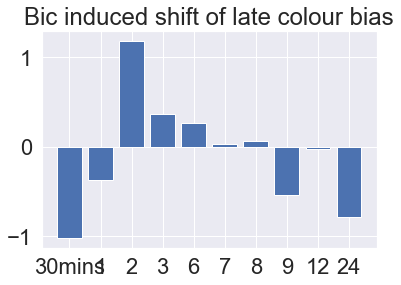

In [152]:
y=[ratiohalfhour,ratio1hr,ratio2hr,ratio3hr,ratio6hr,ratio7hr,ratio8hr,ratio9hr,ratio12hr,ratio24hr]
x=np.arange(1,len(y)+1)
labels=['30mins','1','2','3','6','7','8','9','12','24']
plt.bar(x,height=np.log(y))
plt.xticks(x,labels)
plt.title('Bic induced shift of late colour bias')

In [112]:
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('30'), 'Time'] = '30mins'
df2.loc[df2['exp condition'].str.contains('1hr'), 'Time'] = '1hr'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hr'
df2.loc[df2['exp condition'].str.contains('3hr'), 'Time'] = '3hr'
df2.loc[df2['exp condition'].str.contains('6hr'), 'Time'] = '6hr'
df2.loc[df2['exp condition'].str.contains('7hr'), 'Time'] = '7hr'
df2.loc[df2['exp condition'].str.contains('8hr'), 'Time'] = '8hr'
df2.loc[df2['exp condition'].str.contains('9hr'), 'Time'] = '9hr'
df2.loc[df2['exp condition'].str.contains('12hr'), 'Time'] = '12hr'
df2.loc[df2['exp condition'].str.contains('24hr'), 'Time'] = '24hr'

In [113]:
df2regionprops['Time']='None'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('30'), 'Time'] = '30mins'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('1hr'), 'Time'] = '1hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('2hr'), 'Time'] = '2hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('3hr'), 'Time'] = '3hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('6hr'), 'Time'] = '6hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('7hr'), 'Time'] = '7hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('8hr'), 'Time'] = '8hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('9hr'), 'Time'] = '9hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('12hr'), 'Time'] = '12hr'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('24hr'), 'Time'] = '24hr'
df2regionprops['Timeframe']='None'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('30'), 'Timeframe'] = np.nan
df2regionprops.loc[df2regionprops['exp condition'].str.contains('1hr'), 'Timeframe'] = '1-3hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('2hr'), 'Timeframe'] = '1-3hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('3hr'), 'Timeframe'] = '1-3hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('6hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('7hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('8hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('9hr'), 'Timeframe'] = '6-9hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('12hr'), 'Timeframe'] = '12hrs'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('24hr'), 'Timeframe'] = '24hrs'

NameError: name 'df2regionprops' is not defined

In [114]:
df2['Timeframe']='None'
df2.loc[df2['exp condition'].str.contains('30'), 'Timeframe'] = np.nan
df2.loc[df2['exp condition'].str.contains('1hr'), 'Timeframe'] = '1-3hrs'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Timeframe'] = '1-3hrs'
df2.loc[df2['exp condition'].str.contains('3hr'), 'Timeframe'] = '1-3hrs'
df2.loc[df2['exp condition'].str.contains('6hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('7hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('8hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('9hr'), 'Timeframe'] = '6-9hrs'
df2.loc[df2['exp condition'].str.contains('12hr'), 'Timeframe'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('24hr'), 'Timeframe'] = '24hrs'

In [115]:
df2['Drug']='None'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'

In [ ]:
df2regionprops['Drug']='None'
df2regionprops.loc[df2regionprops['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'

In [51]:
df2.columns

Index(['Autofluorescencedir',
       'Correlation between colour bias (0 shifted) and synapse intensity',
       'Early colour - Mean intensity Normd to ctrls',
       'Early colour - Mean intensity of spots',
       'Early colour - Mean intensity of spots Normd to ctrls',
       'Early colour - Mean spot area [nm]',
       'Early colour - Raw mean intensity',
       'Early colour - Total no. of spots in FOV',
       'Early colour - masked by synapses', 'Early colour - spots mask',
       'Early colour Normd to ctrl - masked by synapses',
       'Early colour/Synapse colour corr (Mean intensity of spots norm to ctrl)',
       'Early colour/Synapse colour corr (Mean intensity of spots)',
       'Earlycontroldir',
       'Global Mean colour bias of a pixel (early=-1<x<1=late)',
       'Global Mean colour bias of a pixel (early=-1<x<1=late) Normd',
       'Global Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls',
       'Global Mean colour bias of a pixel (early=-1<x<1=late)

In [121]:
len(df2[(df2["Drug"]=="None") & (df2["Timeframe"]=="24hrs")])

202

In [145]:
vari="Late colour - Raw mean intensity"

'''mean30minbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="30mins")].mean()
n30minbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="30mins")])
mean30min=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="30mins")].mean()
n30min=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="30mins")])

mean_1hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="1hr")].mean()
n1hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="1hr")])
mean_1hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="1hr")].mean()
n1hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="1hr")])

mean_2hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="2hr")].mean()
n2hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="2hr")])
mean_2hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="2hr")].mean()
n2hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="2hr")])

mean_3hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="3hr")].mean()
n3hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="3hr")])
mean_3hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="3hr")].mean()
n3hr=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="3hr")])

mean_6hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="6hr")].mean()
n6hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="6hr")])
mean_6hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="6hr")].mean()
n6hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="6hr")])

mean_7hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="7hr")].mean()
n7hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="7hr")])
mean_7hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="7hr")].mean()
n7hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="7hr")])

mean_8hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="8hr")].mean()
n8hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="8hr")])
mean_8hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="8hr")].mean()
n8hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="8hr")])

mean_9hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="9hr")].mean()
n9hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="9hr")])
mean_9hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="9hr")].mean()
n9hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="9hr")])

mean_12hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="12hr")].mean()
n12hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="12hr")])
mean_12hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="12hr")].mean()
n12hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="12hr")])

mean_24hourbic=df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="24hr")].mean()
n24hrbic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Time"]=="24hr")])
mean_24hour=df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="24hr")].mean()
n24hr=len(df2[vari][(df2["Drug"]=="None") & (df2["Time"]=="24hr")])'''

mean1to3bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="1-3hrs")].mean()
n1to3bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="1-3hrs")])
mean1to3=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="1-3hrs")].mean()
n1to3=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="1-3hrs")])
mean6to9bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="6-9hrs")].mean()
n6to9bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="6-9hrs")])
mean6to9=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="6-9hrs")].mean()
n6to9=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="6-9hrs")])
mean12bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="12hrs")].mean()
n12bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="12hrs")])
mean12=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="12hrs")].mean()
n12=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="12hrs")])
mean24bic=df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="24hrs")].mean()
n24bic=len(df2[vari][(df2["Drug"]=="Bic") & (df2["Timeframe"]=="24hrs")])
mean24=df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="24hrs")].mean()
n24=len(df2[vari][(df2["Drug"]=="None") & (df2["Timeframe"]=="24hrs")])
ratio1to3=mean1to3bic/mean1to3
ratio6to9=mean6to9bic/mean6to9
#ratio12=mean12bic/mean12
ratio24=mean24bic/mean24



diff30=mean30minbic-mean30min
diff1=mean_1hourbic-mean_1hour
diff2=mean_2hourbic-mean_2hour
diff3=mean_3hourbic-mean_3hour
diff6=mean_6hourbic-mean_6hour
diff7=mean_7hourbic-mean_7hour
diff8=mean_8hourbic-mean_8hour
diff9=mean_9hourbic-mean_9hour
diff12=mean_12hourbic-mean_12hour
diff24=mean_24hourbic-mean_24hour

'''ratiohalfhour=mean30minbic/mean30min
ratio1hr=mean_1hourbic/mean_1hour
#ratio2hr=mean_2hourbic/mean_2hour
ratio3hr=mean_3hourbic/mean_3hour
ratio6hr=mean_6hourbic/mean_6hour
ratio7hr=mean_7hourbic/mean_7hour
ratio8hr=mean_8hourbic/mean_8hour
ratio9hr=mean_9hourbic/mean_9hour
ratio12hr=mean_12hourbic/mean_12hour
ratio24hr=mean_24hourbic/mean_24hour'''

twofoldchange_halfhour=np.log2(mean30minbic)-np.log2(mean30min)
twofoldchange_1hr=np.log2(mean_1hourbic)-np.log2(mean_1hour)
twofoldchange_2hr=np.log2(mean_2hourbic)-np.log2(mean_2hour)
twofoldchange_3hr=np.log2(mean_3hourbic)-np.log2(mean_3hour)
twofoldchange_6hr=np.log2(mean_6hourbic)-np.log2(mean_6hour)
twofoldchange_7hr=np.log2(mean_7hourbic)-np.log2(mean_7hour)
twofoldchange_8hr=np.log2(mean_8hourbic)-np.log2(mean_8hour)
twofoldchange_9hr=np.log2(mean_9hourbic)-np.log2(mean_9hour)
twofoldchange_12hr=np.log2(mean_12hourbic)-np.log2(mean_12hour)
twofoldchange_24hr=np.log2(mean_24hourbic)-np.log2(mean_24hour)


#ns=[n1hr+n1hrbic,n2hr+n2hrbic,n3hr+n3hrbic,n6hr+n6hrbic,n7hr+n7hrbic,n8hr+n8hrbic,n9hr+n9hrbic,n12hr+n12hrbic,n24hr+n24hrbic]
ns=[n1to3bic+n1to3,n6to9bic+n6to9,n24+n24bic]

print(ratiohalfhour,ratio1hr,ratio2hr,ratio3hr,mean_2hour,mean_3hourbic,mean_3hour,mean_6hourbic,mean_6hour,
     mean_7hourbic,mean_7hour,mean_8hourbic,mean_8hour,mean_9hourbic,mean_9hour,mean_12hourbic,mean_12hour,
     mean_24hourbic,mean_24hour)

print(twofoldchange_halfhour,twofoldchange_1hr,twofoldchange_2hr,twofoldchange_3hr,twofoldchange_6hr,
     twofoldchange_7hr,twofoldchange_8hr,twofoldchange_9hr,twofoldchange_12hr,twofoldchange_24hr)

0.6862196592334735 0.6360793991524524 nan nan 0.0 0.0 0.0 0.0 0.0 -0.22995950067417922 -0.21126633762399852 0.22122229261663656 0.18530866162260665 0.0 0.0 0.0 0.0 0.198489564118743 0.18449435898638183
nan nan nan nan nan nan 0.2555664567687179 nan nan 0.10548645175677773


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in log2
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in log2
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log2
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log2
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log2
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ip

In [146]:
y1 = np.log2([ratio1to3,ratio6to9,ratio12hr,ratio24hr])
print(y1)

[ 0.21652709 -0.2996395          nan -0.06233647]


0.2165270899094807
-0.2996395046558016
0.20649153880283896


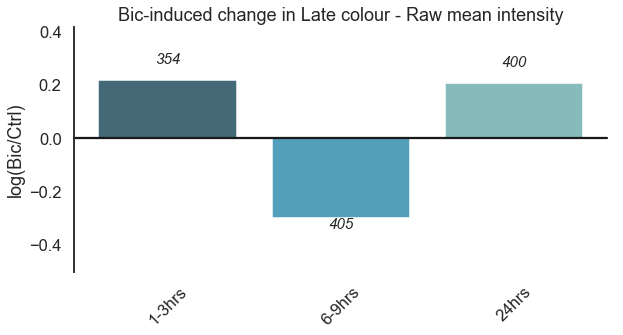

In [147]:
sns.set(style="white", context="talk")
# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(9, 5))

# Generate some sequential data
y2 = np.log2([ratio1hr,ratio2hr,ratio3hr,ratio6hr,ratio7hr,ratio8hr,ratio9hr,ratio12hr,ratio24hr])
#labels=['1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
labels=['1-3hrs','6-9hrs','24hrs']
y1 = ([twofoldchange_1hr,twofoldchange_2hr,twofoldchange_3hr,twofoldchange_6hr,
     twofoldchange_7hr,twofoldchange_8hr,twofoldchange_9hr,twofoldchange_24hr])
y1=([diff1,diff2,diff3,diff6,diff7,diff8,diff9,diff12,diff24])
y3 = np.log2([ratio1to3,ratio6to9,ratio24])


x1 = np.array(labels)
sns.barplot(x=x1, y=y3, palette="GnBu_d", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("log(Bic/Ctrl)")
plt.xticks(rotation=45)
ax1.set_title('Bic-induced change in '+vari)
ax1.set_ylim(top=np.max(y3)+0.2,bottom=np.min(y3)-0.2)
#ax1.set_xlim(left=0,right=5)
ax2=plt.bar(x=np.arange(0,len(y3)),height=y3,visible=False)
counter=0
for i in ax2:
    samples=ns[counter]
    counter=counter+1
    height=i.get_height()
    print(height)
    ax1.text(i.get_x() + i.get_width()/2.0, height+np.sign(height)*0.05, str(samples), ha='center',va='bottom',
             fontsize=15,fontstyle='italic')

sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [76]:
df2.columns

Index(['Autofluorescencedir',
       'Correlation between colour bias (0 shifted) and synapse intensity',
       'Early colour - Mean intensity Normd to ctrls',
       'Early colour - Mean intensity of spots',
       'Early colour - Mean intensity of spots Normd to ctrls',
       'Early colour - Mean spot area [nm]',
       'Early colour - Raw mean intensity',
       'Early colour - Total no. of spots in FOV',
       'Early colour - masked by synapses', 'Early colour - spots mask',
       'Early colour Normd to ctrl - masked by synapses',
       'Early colour/Synapse colour corr (Mean intensity of spots norm to ctrl)',
       'Early colour/Synapse colour corr (Mean intensity of spots)',
       'Earlycontroldir',
       'Global Mean colour bias of a pixel (early=-1<x<1=late)',
       'Global Mean colour bias of a pixel (early=-1<x<1=late) Normd',
       'Global Mean colour bias of a pixel (early=-1<x<1=late) Normd to ctrls',
       'Global Mean colour bias of a pixel (early=-1<x<1=late)

In [78]:
print(df2['filename'][1000])
print(df2['Latecontroldir'][1000])

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180214_Turnover_Bic_TNR_nb580first_nb653psecond_use/2DayBic/20180215_10_60x_005.nd2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180214_Turnover_Bic_TNR_nb580first_nb653psecond_use/Fixedctrl_onlysecondcolour_1day


"yerrorsbic=[Bic1to3.sem(),Bic6to9.sem(),Bic12.sem(),Bic24.sem()]\nyerrorsnobic=[NoBic1to3.sem(),NoBic6to9.sem(),NoBic12.sem(),NoBic24.sem()]\n\nplt.errorbar(x=[0,1,2,3],\n             y=[Bic1to3.mean(),Bic6to9.mean(),Bic12.mean(),Bic24.mean()],\n             yerr=yerrorsbic,xerr=None,ecolor='orange',fmt='none',capsize=2)\nplt.errorbar(x=[0,1,2,3],\n             y=[NoBic1to3.mean(),NoBic6to9.mean(),NoBic12.mean(),NoBic24.mean()],\n             yerr=yerrorsnobic,xerr=None,ecolor='blue',fmt='none',capsize=2)"

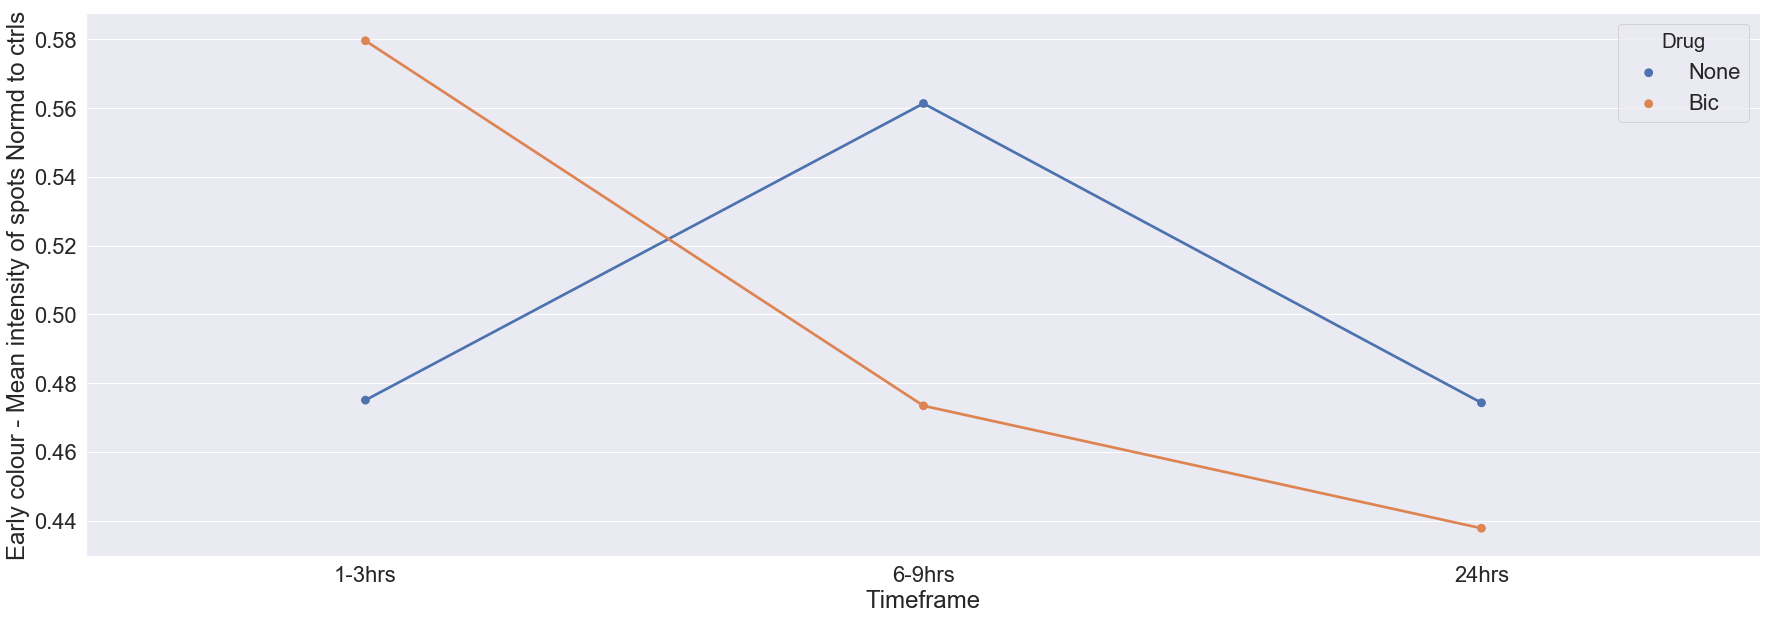

In [149]:
vari="Early colour - Mean intensity of spots Normd to ctrls"


sns.set(font_scale=2)


#orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
orderlab=['1-3hrs','6-9hrs','24hrs']
fig10=plt.figure(figsize=(30,10)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.pointplot(y=vari, x='Timeframe',data=df2,hue='Drug',
                 hue_order=['None','Bic'],ci=None,
                 split=True,order=orderlab)
Bic1to3=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="1-3hrs")][vari]
NoBic1to3=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="1-3hrs")][vari]
Bic6to9=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="6-9hrs")][vari]
NoBic6to9=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="6-9hrs")][vari]
#Bic12=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="12hrs")][vari]
#NoBic12=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="12hrs")][vari]
Bic24=df2[(df2["Drug"]=="Bic")&(df2["Timeframe"]=="24hrs")][vari]
NoBic24=df2[(df2["Drug"]=="None")&(df2["Timeframe"]=="24hrs")][vari]

'''yerrorsbic=[Bic1to3.sem(),Bic6to9.sem(),Bic12.sem(),Bic24.sem()]
yerrorsnobic=[NoBic1to3.sem(),NoBic6to9.sem(),NoBic12.sem(),NoBic24.sem()]

plt.errorbar(x=[0,1,2,3],
             y=[Bic1to3.mean(),Bic6to9.mean(),Bic12.mean(),Bic24.mean()],
             yerr=yerrorsbic,xerr=None,ecolor='orange',fmt='none',capsize=2)
plt.errorbar(x=[0,1,2,3],
             y=[NoBic1to3.mean(),NoBic6to9.mean(),NoBic12.mean(),NoBic24.mean()],
             yerr=yerrorsnobic,xerr=None,ecolor='blue',fmt='none',capsize=2)'''


In [ ]:
vari1="Late colour - Mean intensity of spots"
vari2="Synapse colour - Mean intensity of spots"

sns.set(font_scale=1)


#orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']
orderlab=['1-3hrs','6-9hrs','12hrs','24hrs']
plt.figure(figsize=(60,30)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.relplot(x=vari1, y=vari2,col="Timeframe",data=df2,
                  hue='Drug',col_order=orderlab)



0.012595990349462419


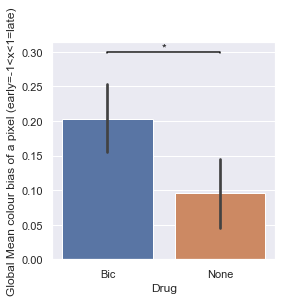

In [82]:
sns.set(font_scale=1)
varib="Global Mean colour bias of a pixel (early=-1<x<1=late)"

orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(4,4)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.barplot(y=varib, x='Drug',data=df2[df2["Timeframe"]=="24hrs"],ci=90,)
Nobic = df2[(df2["Timeframe"]=="24hrs") & (df2["Drug"]=="None")][varib]
Bic = df2[(df2["Timeframe"]=="24hrs") & (df2["Drug"]=="Bic")][varib]
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df2[df2["Timeframe"]=="24hrs"][varib].mean() + 0.15, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)



In [ ]:
sns.set(font_scale=2)


orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(30,10)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.pointplot(y='Late colour - Raw mean intensity', x='Time',data=df2,hue='Drug',
                 order=orderlab,hue_order=['None','Bic'],
                 split=True)
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')

In [ ]:
sns.set(font_scale=2)


orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(30,10)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.pointplot(y='Late colour - Mean intensity of spots', x='Time',data=df2,hue='Drug',
                 order=orderlab,hue_order=['None','Bic'],
                 split=True)
#d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late) Raw', y='exp condition',data=df2,color='black')

In [ ]:
mean_1daybic=np.mean(df2[df2['exp condition']==onedaybiclabel]['Late colour - Mean intensity of spots'])
mean_1day=np.mean(df2[df2['exp condition']==onedaylabel]['Late colour - Mean intensity of spots'])
mean_1hourbic=np.mean(df2[df2['exp condition']==onehourbiclabel]['Late colour - Mean intensity of spots'])
mean_1hour=np.mean(df2[df2['exp condition']==onehourlabel]['Late colour - Mean intensity of spots'])
mean_7hourbic=np.mean(df2[df2['exp condition']==sevenhourbiclabel]['Late colour - Mean intensity of spots'])
mean_7hour=np.mean(df2[df2['exp condition']==sevenhourlabel]['Late colour - Mean intensity of spots'])
mean30minbic=np.mean(df2[df2['exp condition']==thirtyminsbiclabel]['Late colour - Mean intensity of spots'])
mean_30min=np.mean(df2[df2['exp condition']==thirtyminslabel]['Late colour - Mean intensity of spots'])
mean_2hourbic=np.mean(df2[df2['exp condition']==twohourbiclabel]['Late colour - Mean intensity of spots'])
mean_2hour=np.mean(df2[df2['exp condition']==twohourlabel]['Late colour - Mean intensity of spots'])
mean_6hourbic=np.mean(df2[df2['exp condition']==sixhourbiclabel]['Late colour - Mean intensity of spots'])
mean_6hour=np.mean(df2[df2['exp condition']==sixhourlabel]['Late colour - Mean intensity of spots'])
mean_9hourbic=np.mean(df2[df2['exp condition']==ninehourbiclabel]['Late colour - Mean intensity of spots'])
mean_9hour=np.mean(df2[df2['exp condition']==ninehourlabel]['Late colour - Mean intensity of spots'])
mean_3hourbic=np.mean(df2[df2['exp condition']==threehourbiclabel]['Late colour - Mean intensity of spots'])
mean_3hour=np.mean(df2[df2['exp condition']==threehourlabel]['Late colour - Mean intensity of spots'])
mean_12hourbic=np.mean(df2[df2['exp condition']==twelvehourbiclabel]['Late colour - Mean intensity of spots'])
mean_12hour=np.mean(df2[df2['exp condition']==twelvehourlabel]['Late colour - Mean intensity of spots'])
mean_8hourbic=np.mean(df2[df2['exp condition']==eighthourbiclabel]['Late colour - Mean intensity of spots'])
mean_8hour=np.mean(df2[df2['exp condition']==eighthourlabel]['Late colour - Mean intensity of spots'])
mean_48hourbic=np.mean(df2[df2['exp condition']==twodaybiclabel]['Late colour - Mean intensity of spots'])
mean_48hour=np.mean(df2[df2['exp condition']==twodaylabel]['Late colour - Mean intensity of spots'])
mean_72hourbic=np.mean(df2[df2['exp condition']==threedaybiclabel]['Late colour - Mean intensity of spots'])
mean_72hour=np.mean(df2[df2['exp condition']==threedaylabel]['Late colour - Mean intensity of spots'])


ratiohalfhour=mean30minbic/mean_30min
ratio1hr=mean_1hourbic/mean_1hour
ratio2hr=mean_2hourbic/mean_2hour
ratio3hr=mean_3hourbic/mean_3hour
ratio6hr=mean_6hourbic/mean_6hour
ratio7hr=mean_7hourbic/mean_7hour
ratio8hr=mean_8hourbic/mean_8hour
ratio9hr=mean_9hourbic/mean_9hour
ratio12hr=mean_12hourbic/mean_12hour
ratio24hr=mean_1daybic/mean_1day
ratio48hr=mean_48hourbic/mean_48hour
ratio72hr=mean_72hourbic/mean_72hour

y=[ratiohalfhour,ratio1hr,ratio2hr,ratio3hr,ratio6hr,ratio7hr,ratio8hr,ratio9hr,ratio12hr,ratio24hr]
x=np.arange(1,len(x)+1)
labels=['30mins','1','2','3','6','7','8','9','12','24']
plt.bar(x,height=np.log10(y))
plt.xticks(x,labels)
plt.title('Bic induced shift of Late colour bias')

In [ ]:
props=df2regionprops["Early colour - regionprops"].iloc[0]

In [ ]:
df3regionprops.columns

In [ ]:
df3regionprops=deepcopy(df2regionprops)

In [ ]:
for j in range(0,len(props)):
    print(props[j].perimeter)

In [ ]:
df3regionprops['Eccentricity early']=[list() for x in range(len(df3regionprops.index))]
df3regionprops['Eccentricity late']=[list() for x in range(len(df3regionprops.index))]
df3regionprops['Eccentricity early plus late']=[list() for x in range(len(df3regionprops.index))]

In [ ]:
for i in range(0,len(df3regionprops)):
    #empty vecs
    
    props_early=df3regionprops["Early colour - regionprops"].iloc[i]
    props_early_perim=np.zeros((len(props_early),1))
    for j in range(0,len(props_early)):
        props_early_perim[j]=props_early[j].perimeter
    df3regionprops['Perimeter early'].iloc[i]=props_early_perim
    
    props_late=df3regionprops["Late colour - regionprops"].iloc[i]
    props_late_perim=np.zeros((len(props_late),1))
    for j in range(0,len(props_late)):
        props_late_perim[j]=props_late[j].perimeter
    df3regionprops['Perimeter late'].iloc[i]=props_late_perim
    
    props_earlylate=df3regionprops["Late + early colour combined - regionprops"].iloc[i]
    props_earlylate_perim=np.zeros((len(props_earlylate),1))
    for j in range(0,len(props_earlylate)):
        props_earlylate_perim[j]=props_earlylate[j].perimeter
    df3regionprops['Perimeter early plus late'].iloc[i]=props_earlylate_perim

### Regionprops plots

In [ ]:
df3regionprops['Eccentricity early plus late mean']=np.nan

In [ ]:
for i in range(0,len(df3regionprops)):
    
    df3regionprops['Perimeter early plus late mean'].iloc[i]=df3regionprops["Perimeter early plus late"].iloc[i].mean()

In [ ]:
sns.set(font_scale=1)
varib1=df3regionprops["Perimeter early mean"].values.tolist()
varib2=df3regionprops["Perimeter early plus late mean"].values.tolist()

sns.kdeplot(varib1, shade=True, cut=0, label="early")
sns.kdeplot(varib2, shade=True, cut=0,label="early+late")



In [ ]:
sns.set(font_scale=1)
varib="Perimeter early mean"

orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(4,4)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.barplot(y=varib, x='Drug',data=df3regionprops,hue="Timeframe",ci=90,)
Nobic = df3regionprops[(df3regionprops["Timeframe"]=="24hrs") & (df3regionprops["Drug"]=="None")][varib]
Bic = df3regionprops[(df3regionprops["Timeframe"]=="24hrs") & (df3regionprops["Drug"]=="Bic")][varib]
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df3regionprops[df3regionprops["Timeframe"]=="24hrs"][varib].mean() + 0.15, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)





In [ ]:
sns.set(font_scale=1)
varib="Perimeter early mean"

orderlab=['30mins','1hr','2hr','3hr','6hr','7hr','8hr','9hr','12hr','24hr']

fig10=plt.figure(figsize=(4,4)) #
#sns.pointplot('size', 'total_bill', 'sex', tips, dodge=True)
d=sns.barplot(y=varib, x='Drug',data=df3regionprops[df3regionprops["Timeframe"]=="1-3hrs"],ci=None,)
Nobic = df3regionprops[(df3regionprops["Timeframe"]=="1-3hrs") & (df3regionprops["Drug"]=="None")][varib]
Bic = df3regionprops[(df3regionprops["Timeframe"]=="1-3hrs") & (df3regionprops["Drug"]=="Bic")][varib]
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df3regionprops[df3regionprops["Timeframe"]=="1-3hrs"][varib].mean() + 50, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.errorbar(theta, E, yerr=0.09, xerr=0.023, capsize=0, color='#0000ff', fmt='none')

if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)


    
#ax2=plt.bar(x=[0,1],height=[Nobic.mean(),Bic.mean()],visible=False)
yerrors=[Nobic.sem(),Bic.sem()]
plt.errorbar(x=[0,1],y=[Nobic.mean(),Bic.mean()],yerr=yerrors,xerr=None,ecolor='black',fmt='none',capsize=2)


In [ ]:
yerrors

### Make bias image files for printing

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


'''for condition in np.unique(df["exp condition"]):
    pdf_pages = PdfPages(expdir+'/results/'+condition + '_images_print.pdf')

    #make dictionary for files in this condition only
    exp_condition_images = [df["filename"][idx] for idx, x in enumerate(df["exp condition"]) if x == condition ]
    exp_condition_images=np.unique(exp_condition_images)
    no_images_cond=len(exp_condition_images)

    figno=1
    fig=plt.figure(figsize=(20,70))'''

for i in range(1600,1601):    
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    early_channel_no=results["earlychannelno"][i]
    late_channel_no=results["latechannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        #read the images
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        #convert to array
        early_image=early_image.astype(np.int16)
        late_image=late_image.astype(np.int16)
        #normalize intensity to value between 0 and 1
        early_image=np.divide(early_image,16383.)
        late_image=np.divide(late_image,16383.)
        #small detour to calculate the autofluorescence
        autof={"filename":[]}
        autofpath=results["Autofluorescencedir"][i]
        if autofpath==0:
            early_autoint_mean=0
            late_autoint_mean=0
            if synapse_flag:
                synapse_autoint_mean=0
        else:
            pathy = os.path.dirname(autofpath+"/")  
            autoffilelist = []
            for root, _, filenames in os.walk(pathy):
                 for filename in filenames:
                     autoffilelist.append(os.path.join(root, filename))
            for i in range(0,len(autoffilelist)):
                if autoffilelist[i].endswith(".nd2"): 
                    autof["filename"].append(autoffilelist[i])
            earlycolour_autoint=np.zeros((len(autof["filename"]),1))
            latecolour_autoint=np.zeros((len(autof["filename"]),1))
            if synapse_flag:
                synapsecolour_autoint=np.zeros((len(autof["filename"]),1))
            for im in range(0,len(autof["filename"])):
                with ND2Reader(autof["filename"][im]) as images:
                    early_image=images[early_channel_no-1]
                    late_image=images[late_channel_no-1]
                    if synapse_flag:
                        synapse_image=images[synapse_channel_no-1]
                    #convert to array
                    early_image=early_image.astype(np.int16)
                    late_image=late_image.astype(np.int16)
                    if synapse_flag:
                        synapse_image=synapse_image.astype(np.int16)
                    #normalize intensity to value between 0 and 1
                    early_image=np.divide(early_image,16383.)
                    late_image=np.divide(late_image,16383.)
                    if synapse_flag:
                        synapse_image=np.divide(synapse_image,16383.)
                    #append mean intensity
                    earlycolour_autoint[i]=np.mean(early_image)
                    latecolour_autoint[i]=np.mean(late_image)  
                    if synapse_flag:
                        synapsecolour_autoint[i]=np.mean(synapse_image)
            #average the vectors
            early_autoint_mean=np.mean(earlycolour_autoint)
            late_autoint_mean=np.mean(latecolour_autoint) 
        #subtract autofluorescence in each channel; subtract the normalized pixel value times the max autofluorescence int
        early_image=np.subtract(early_image,early_autoint_mean)
        early_image[early_image<0]=0
        late_image=np.subtract(late_image,late_autoint_mean)
        late_image[late_image<0]=0
        #read spots masks
        early_spots=results["Early colour - spots mask"][i]
        late_spots=results["Late colour - spots mask"][i]
        lateplusearly_spots=results["Late plus early colour - spots mask"][i]
        a=late_image#[lateplusearly_spots]
        b=early_image#[lateplusearly_spots]
        spots_bias_image=(a-b)/(a+b)
        biastoearly=deepcopy(spots_bias_image)
        biasonlylate_image=deepcopy(spots_bias_image)
        biasonlylate_image=biasonlylate_image-biasonlylate_image.min()
        biasonlylate_image[~lateplusearly_spots]=0
        biasonlylate_image[biasonlylate_image<0.6*biasonlylate_image.max()]=0
        biasonlylate_mask=biasonlylate_image>0
        earlyimageverylatebias=deepcopy(early_image)
        earlyimageverylatebias[biasonlylate_mask]=np.nan

In [ ]:
cmap = plt.cm.jet
cmap.set_bad('r',1.)
plt.imshow(earlyimageverylatebias, interpolation='none', cmap=cmap,
           vmin=3*early_image.min(),
           vmax=0.65*early_image.max())


In [ ]:
fig=plt.figure()
fig.add_subplot(121)
plt.imshow(verybiased,cmap='gray',vmin=verybiased.min(),vmax=verybiased.max())
plt.colorbar()
fig.add_subplot(122)
plt.imshow(early_image,interpolation='none',cmap='gray')

In [ ]:

    
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(y="Early colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],ci=95)
#d=sns.swarmplot(y="Early colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],color='black')
#ig1.savefig(expdir+'plot1.png',bbox_inches='tight')
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Early colour - Raw mean intensity']
Bic = df_corrected[df_corrected['exp condition'] == '1DayBic']['Early colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Early colour - Raw mean intensity'].mean() + 0.005, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

fig2=plt.figure()
d=sns.barplot(y="Late colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],ci=95)
#d=sns.swarmplot(y="Late colour - Raw mean intensity", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],color='black')
#ig1.savefig(expdir+'plot1.png',bbox_inches='tight')
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Late colour - Raw mean intensity']
Bic = df_corrected[df_corrected['exp condition'] == '1DayBic']['Late colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Late colour - Raw mean intensity'].mean() + 0.005, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
#fig2.savefig(expdir+'plot2.png',bbox_inches='tight')

fig10=plt.figure()
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df_corrected[df_corrected['exp condition'] == '1DayBic']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
d=sns.barplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])],ci=95)
#d=sns.swarmplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected,color='black')
#fig10.savefig(expdir+'plot10.png',bbox_inches='tight')
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Mean colour bias of a pixel (early=-1<x<1=late)'].mean() + 0.25, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

In [ ]:
data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','1DayBic'])]

In [ ]:
'''fig10=plt.figure()
Nobic = df[df['exp condition'] == '1Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df[df['exp condition'] == '2Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic)
print(pval)
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_corrected[df_corrected['exp condition'].isin(['1Day', '2Day'])], ci='sd')
d=sns.swarmplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_corrected[df_corrected['exp condition'].isin(['1Day', '2Day'])],color='black')
fig10.savefig(expdir+'plot10.png',bbox_inches='tight')'''


fig10=plt.figure()
Nobic = df_corrected[df_corrected['exp condition'] == '1Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
Bic = df_corrected[df_corrected['exp condition'] == '2Day']['Mean colour bias of a pixel (early=-1<x<1=late)']
[stat,pval]=stats.ttest_ind(Nobic, Bic,nan_policy='omit')
print(pval)
d=sns.barplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected.loc[df_corrected['exp condition'].isin(['1Day','2Day'])])
#d=sns.swarmplot(y="Mean colour bias of a pixel (early=-1<x<1=late)", x="exp condition",data=df_corrected,color='black')
#fig10.savefig(expdir+'plot10.png',bbox_inches='tight')
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df_corrected['Mean colour bias of a pixel (early=-1<x<1=late)'].mean() + 0.8, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)